In [1]:
import sys, os, re
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml, json
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
pio.renderers.default = "browser"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join('..', 'preprocessing')))
sys.path.append(os.path.abspath(os.path.join('..', 'cellTV')))

import preprocessing.parse_session_functions_cohort2 as parse_session_functions
import neural_analysis_helpers
import alternation_analysis_helpers as alternation
import cellTV.cellTV_functions_cohort2 as cellTV

importlib.reload(parse_session_functions)
importlib.reload(neural_analysis_helpers)
importlib.reload(alternation)
importlib.reload(cellTV)

import palettes
tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)
hfs_palette = np.array(palettes.met_brew('Austria',n=8, brew_type="continuous"))

In [ ]:
# Palette testing
# cont_palette = palettes.met_brew('Johnson',n=16, brew_type="continuous")
# fig,ax = plt.subplots(1,1)
# ax.bar(range(16), np.ones(16), capsize=3, color=cont_palette[:16])

# Discrete: Archambault, Austria, Cross, Johnson
# Continuous: VanGogh1, Pillement


#### Load data

Working on T5
DF_F0 file found. Loading...
(624, 78437)
Training and Imaging
Total rewards considered here:  101
Total rewards not considered here:  9
Total assistant and manual rewards:  9
Reward time lag from lm entry:  29.0
Total licks considered here:  2694


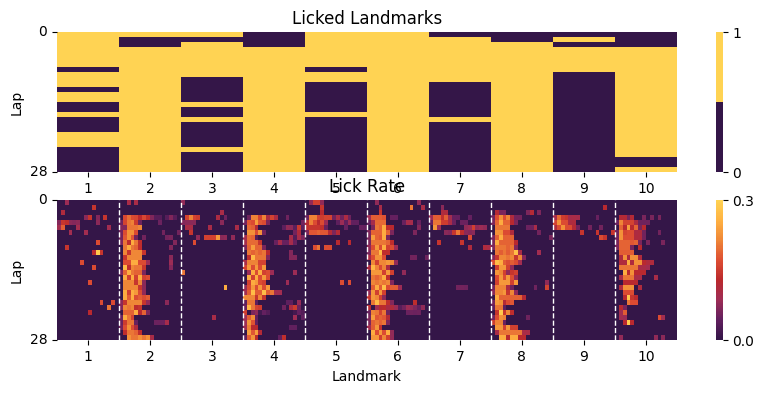

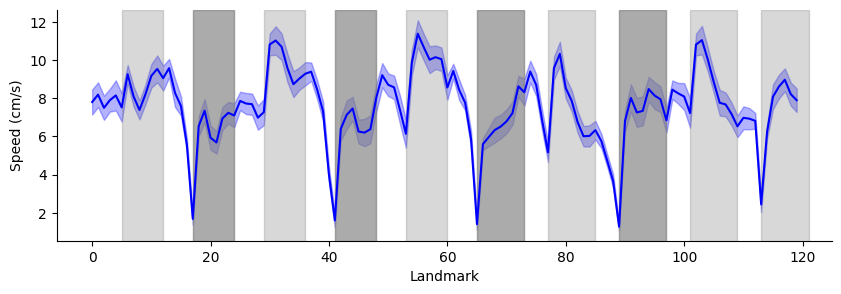

Number of laps =  1
Training and Imaging


In [ ]:
# Define relevant directories and session specific info
base_path = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
mouse = 'TAA0000066'
date = '20250315'
sess = 'ses-011_date-20250315_protocol-t5'
sess_data_path = base_path / mouse / sess
funcimg_path = 'funcimg/Session'

protocol_num = int(re.search(r'protocol-t(\d+)', sess).group(1))
print(f'Working on T{protocol_num}')

# Load data 
save_path, DF_F, session = neural_analysis_helpers.load_dF_session_data(base_path, mouse, stage='-t5')

behav_path = parse_session_functions.find_base_path(mouse, date)
VR_data = parse_session_functions.load_session(str(behav_path))
behav_path_npz = parse_session_functions.find_base_path_npz(mouse, date)
nidaq_data = parse_session_functions.load_session_npz(str(behav_path_npz))

# Load suite2p outputs
ops = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/iscell.npy'))[:,0]

neurons = np.where(iscell == 1)[0]  # select ROIs that are classified as neurons
num_neurons = len(neurons)

# Other variables
ABCD_goals = [1,2,3,4]
funcimg_frame_rate = 45
num_lms = len(session['all_lms'])
lm_entry_idx, lm_exit_idx = parse_session_functions.get_lm_entry_exit(session)


#### Compute DF/F

In [ ]:
# Load F and Fneu
calculate_DF_F = False

DF_F_file = os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/DF_F0.npy')

if os.path.exists(DF_F_file) and calculate_DF_F is False:
    print('DF_F0 file found. Loading...')
    valid_frames = np.load(os.path.join(sess_data_path, 'valid_frames.npz'))['valid_frames']

    DF_F_all = np.load(DF_F_file)
    DF_F = DF_F_all[:, valid_frames]
    print(DF_F.shape)
    
else:
    calculate_DF_F = True
    F = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/F.npy'))
    Fneu = np.load(os.path.join(sess_data_path, funcimg_path, 'suite2p/plane0/Fneu.npy'))

DF_F0 file found. Loading...
(624, 78437)


In [7]:
# Option 1 - Sandra: using moving percentile for F0 (https://www.nature.com/articles/s41586-021-03452-z#Sec7)
# F0 is defined as the 25th percentile of the fluorescence trace in a sliding window of 60 s
# The average green fluorescence signal was extracted for each cell and then corrected for neuropil contamination 
# by subtracting the signal of 30 μm surrounding each cell multiplied by 0.7 and adding the median multiplied by 0.7

if calculate_DF_F:
    Fcorr = F - 0.7 * Fneu + 0.7 * np.median(Fneu, axis=1).reshape(-1,1)

    F0 = np.zeros(np.shape(F))
    f0_window = 60 * funcimg_frame_rate  # frames
    for n in neurons:  # Loop over neurons (rows)
        F0[n, :] = percentile_filter(F[n, :], percentile=25, size=f0_window, mode='nearest')

    DF_F_all = (Fcorr - F0) / F0  # Compute DF/F as (F-F0)/F0 per frame per neuron

    # Select the correct frames that fall within VR behaviour 
    DF_F = DF_F_all[:, valid_frames]

    for n in neurons[0:10]:
        plt.figure()
        plt.plot(F[n,0:2000], label='F')
        plt.plot(Fcorr[n,0:2000], label='Fcorr')
        plt.plot(F0[n,0:2000], label='F0')
        plt.plot(DF_F[n,0:2000], label='DF/F0')
        plt.legend()

In [ ]:
# Option 2 - suite2p: and dividing by mean F0 (https://github.com/MouseLand/suite2p/issues/598)
# For computing and subtracting baseline:
# baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
# sig_baseline: in bins, standard deviation of gaussian with which to smooth
# win_baseline: in seconds, window in which to compute max/min filters
# if calculate_DF_F:
#     prctile_baseline = 25

#     F0 = 0.7 * Fneu
#     mean_F0 = np.mean(F0, axis=1)

#     DF = F.copy() - F0
#     DF = dcnv.preprocess(DF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], prctile_baseline)

#     DF_F_all = DF / mean_F0.reshape(-1, 1)  # normalize by mean F0  (https://suite2p.readthedocs.io/en/latest/FAQ.html)

#     # Select the correct frames that fall within VR behaviour 
#     DF_F = DF_F_all[:, valid_frames]
#     print(DF_F.shape)

#     for n in neurons[0:10]:
#         plt.figure()
#         plt.plot(F[n,0:2000], label='F')
#         plt.plot(F0[n,0:2000], label='F0')
#         plt.plot(DF_F[n,0:2000], label='DF/F0')
#         plt.legend()

#     # Save nidaq_data 
#     np.save(DF_F_file, DF_F_all)

In [9]:
# Option 3 - suite2p: but adding arbitrary value to F0 computed by suite2p to avoid division by zero.

# prctile_baseline = 25

# F0 = 0.7 * (Fneu + 15)  # add arbitrary value to F0 computed by suite2p 

# DF = F.copy() - F0
# DF = dcnv.preprocess(DF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], prctile_baseline)

# DF_F_all = DF / F0

# # Select the correct frames that fall within VR behaviour 
# DF_F = DF_F_all[:, valid_frames]
# print(DF_F.shape)

# for n in neurons[0:10]:
#     plt.figure()
#     plt.plot(F[n,0:2000], label='F')
#     plt.plot(F0[n,0:2000], label='F0')
#     plt.plot(DF_F[n,0:2000], label='DF/F0')
#     plt.legend()

In [ ]:
# Option 4 - Shohei: Gaussian mixture model on F (https://www.nature.com/articles/s41586-024-07851-w#Sec6)
# Calcium ΔF/F0 signals were obtained by using the baseline fluorescence F0, which is estimated by a 
# Gaussian mixture model with two components fitted on the raw fluorescence nidaq_data. The mean parameter of 
# the lowest Gaussian component is used as F0. 
# from sklearn.mixture import GaussianMixture

# def estimate_f0_gmm(trace):
#     # Fit GMM with 2 components
#     gmm = GaussianMixture(n_components=2, random_state=0)
#     gmm.fit(trace.reshape(-1, 1))

#     # Get the means of the components
#     means = gmm.means_.flatten()
        
#     # Select the mean of the component with the lowest mean value
#     f0 = np.min(means)

#     return f0

# F0 = np.array([estimate_f0_gmm(trace) for trace in F])
# print(F0.shape)

# DF_F_all = (F - F0[:, np.newaxis]) / F0[:, np.newaxis]

# # Select the correct frames that fall within VR behaviour 
# DF_F = DF_F_all[:, valid_frames]
# print(DF_F.shape)

# for n in neurons[0:10]:
#     plt.figure()
#     plt.plot(F[n, :2000], label='F')
#     plt.axhline(F0[n], color='gray', linestyle='--', label='F0')
#     plt.plot(DF_F_all[n, :2000], label='ΔF/F₀')
#     plt.legend()


Out of the 624 ROIs, 517 are classified as neurons, and 319 have time-varying Ca2+ signals and will be considered here.


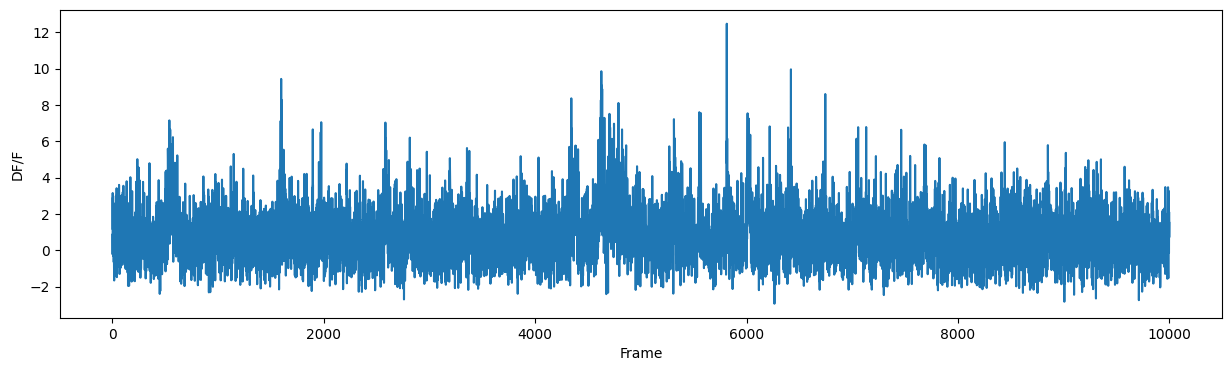

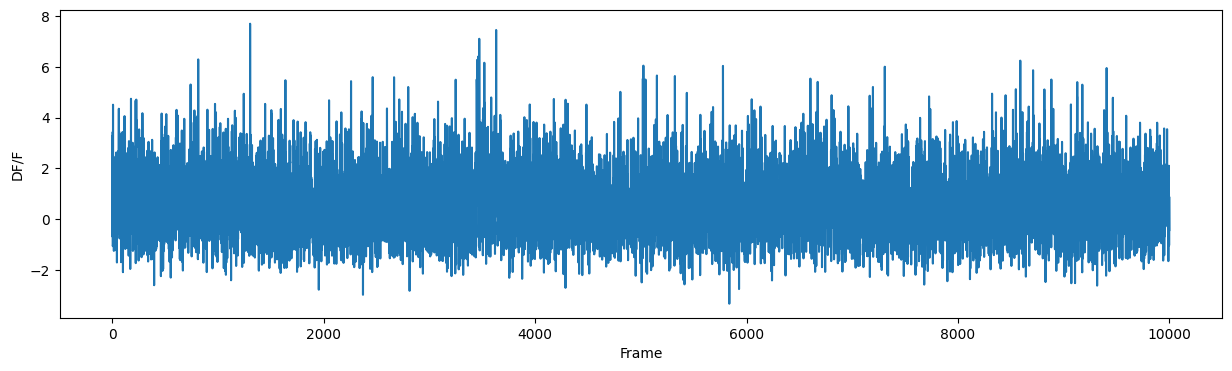

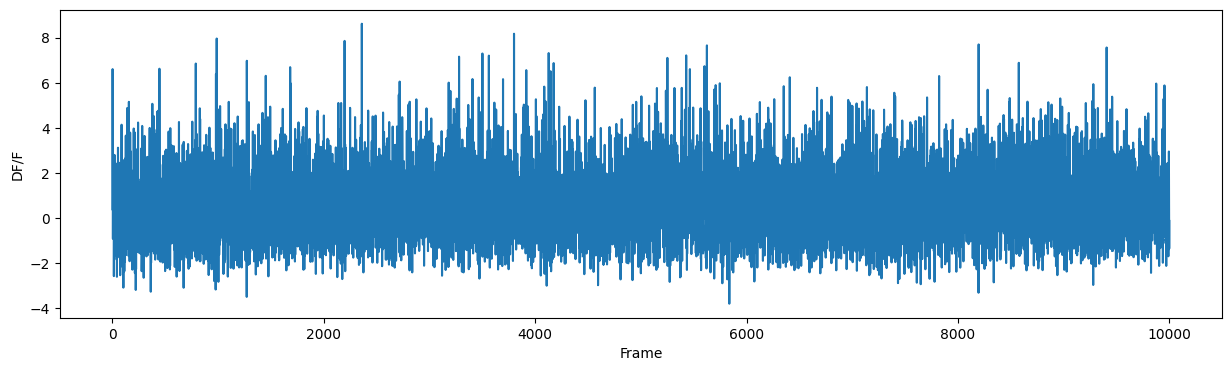

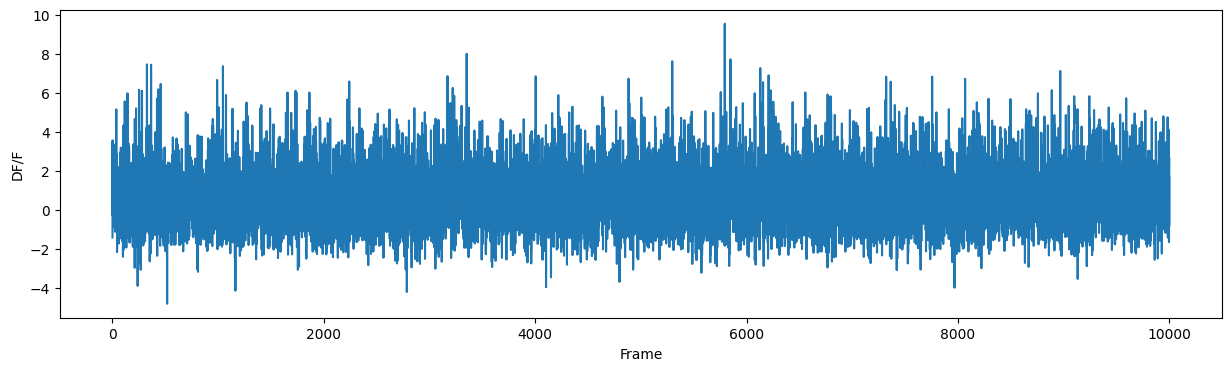

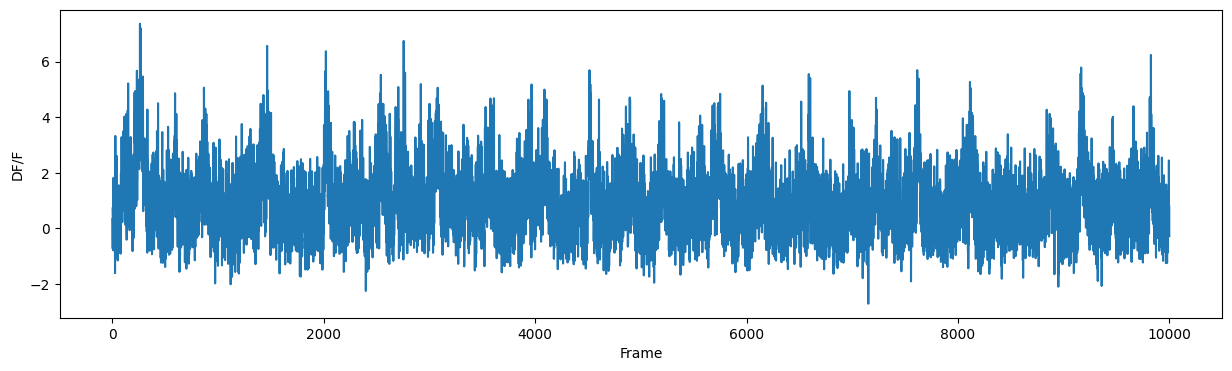

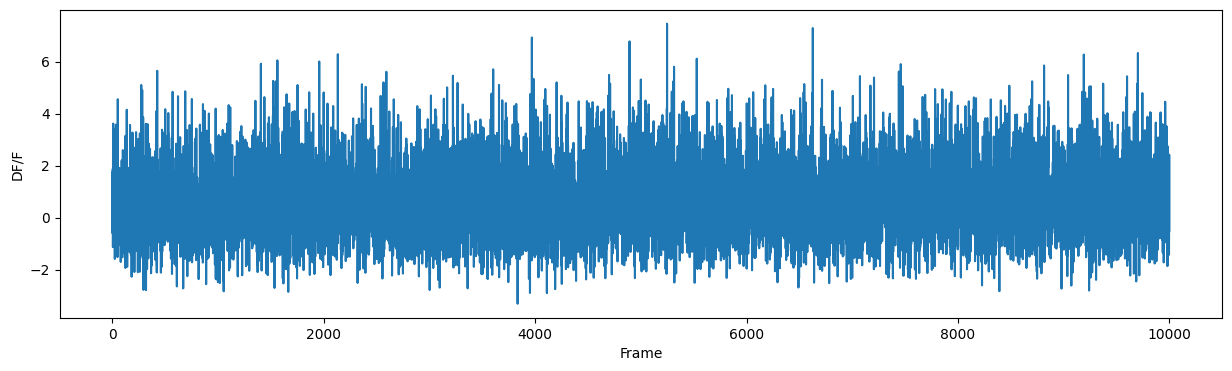

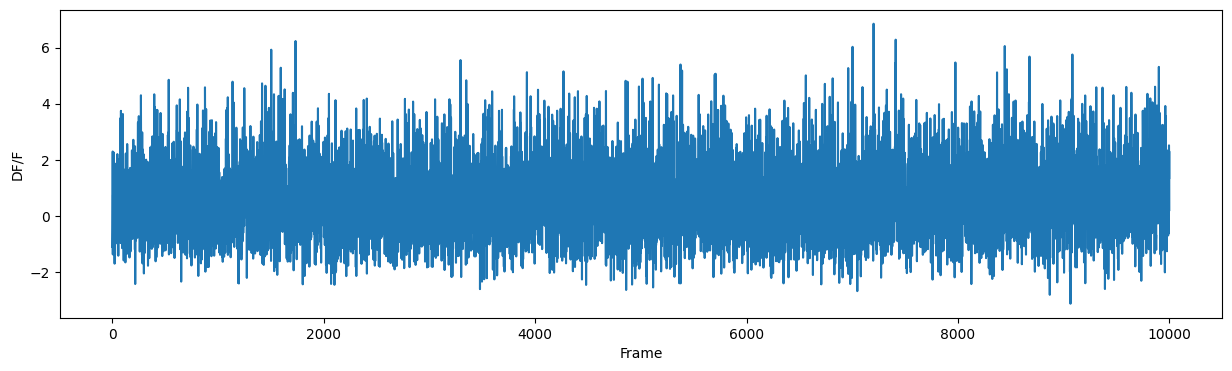

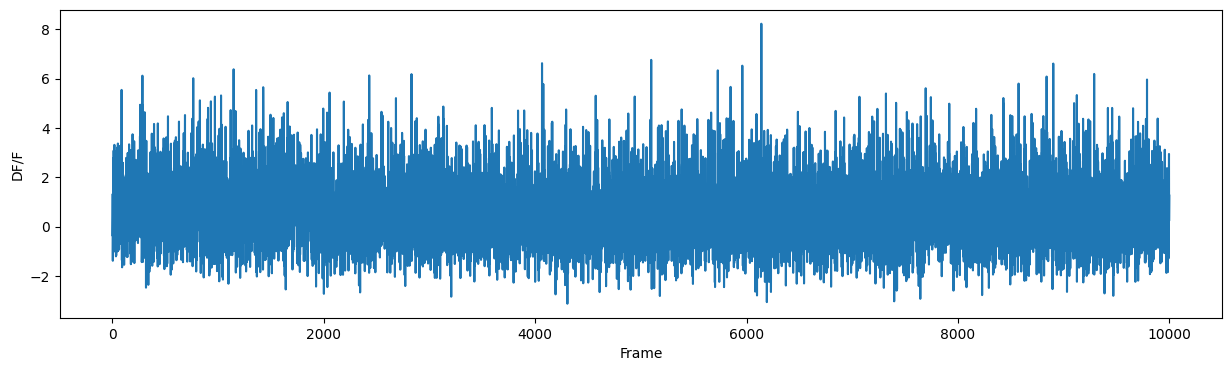

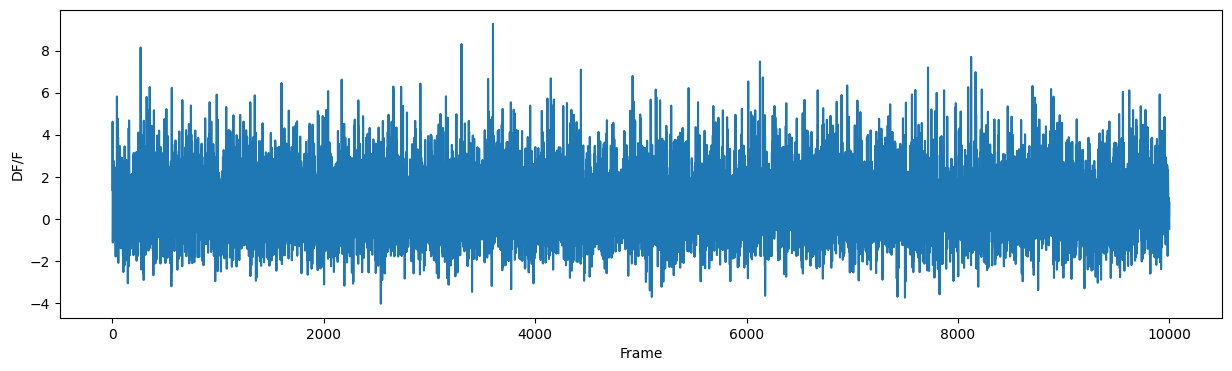

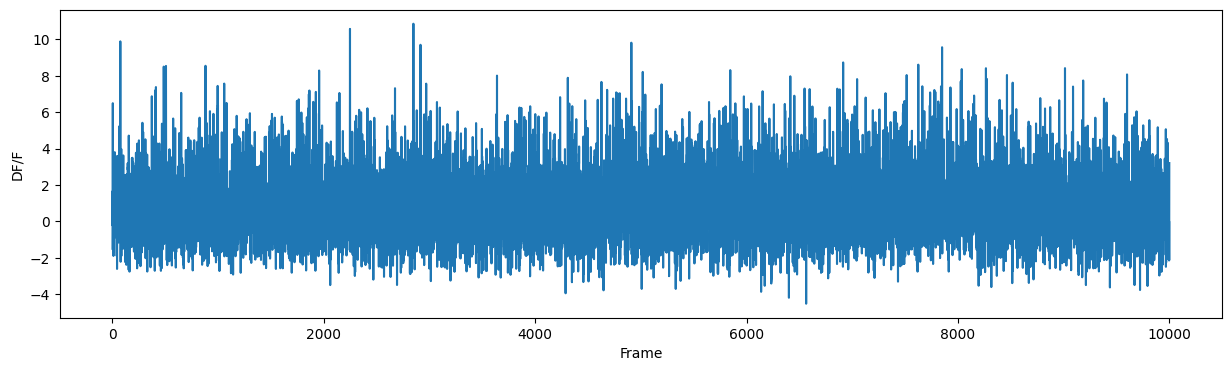

In [11]:
# Look at distribution of DF/F to select neurons
neurons_considered = []

for n in neurons: 
    deltas = DF_F[n,:] - np.mean(DF_F[n,:])
    # plt.hist(deltas, bins=100)
    skew = stats.skew(deltas)

    if np.abs(skew) > 0.5:  # TODO: confirm 
        neurons_considered.append(n)

num_neurons_considered = len(neurons_considered)
print(f'Out of the {DF_F.shape[0]} ROIs, {num_neurons} are classified as neurons, and {num_neurons_considered} have time-varying Ca2+ signals and will be considered here.')

neurons_considered = np.array(neurons_considered)
np.savez(os.path.join(save_path, f'T{protocol_num}_neurons_considered.npz'), neurons_considered)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in neurons_considered[0:10]:
    fig, ax = plt.subplots(1, 1, figsize=(15,4), sharey=True)
    ax.plot(xdata, DF_F[n,0:plot_range])
    ax.set_xlabel('Frame')
    ax.set_ylabel('DF/F')

In [ ]:
# Compare with deconvoluted spikes
# plot_range = 10000
# xdata = np.arange(0, plot_range) 

# for n in neurons_considered[0:10]:
#     fig, ax = plt.subplots(1, 1, figsize=(15,4), sharey=True)
#     ax.plot(xdata, DF_F[n,0:plot_range], label='DF/F0')
#     ax.plot(xdata, nidaq_data['Ca_traces'][n,0:plot_range], alpha=0.5, label='spikes')
#     ax.set_xlabel('Frame')
#     ax.set_ylabel('DF/F')
#     ax.legend()

#### Reward PSTH 

In [13]:
# Initialize saving variables
time_around = 1
save_filename = os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')
reload_results = True
save_plot = False 

if os.path.exists(save_filename) and not reload_results:
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_rewards = {}

67 neurons are tuned to reward.


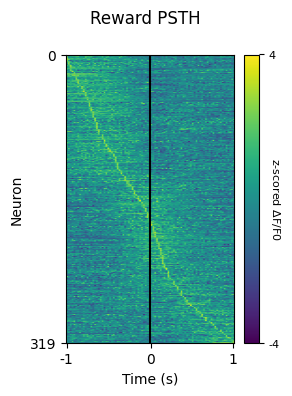

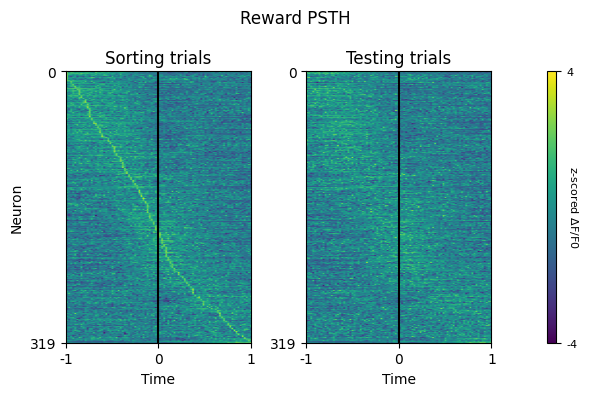

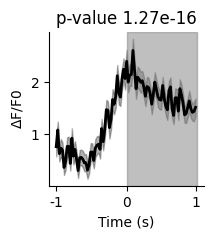

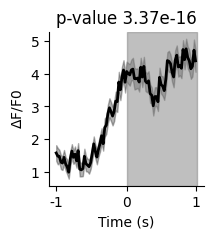

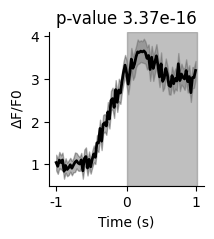

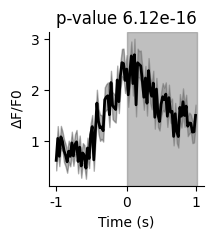

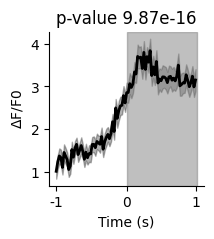

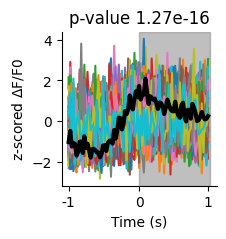

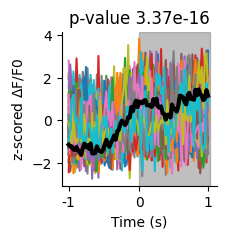

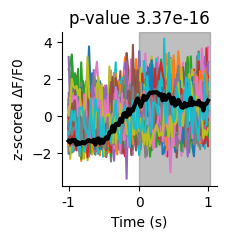

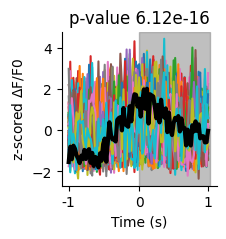

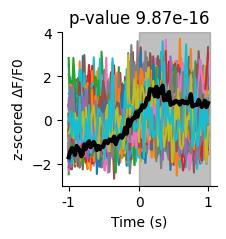

In [ ]:
# Get reward PSTH
if reload_results:
    reward_psth, average_reward_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, event_idx=session['reward_idx'], \
                                                            time_around=time_around)

    neural_analysis_helpers.plot_avg_psth(average_psth=average_reward_psth, event='Reward', zscoring=True, time_around=time_around)

    neural_analysis_helpers.split_psth(psth=reward_psth, event_idx=session['reward_idx'], event='Reward', zscoring=True, time_around=time_around)

    # Get reward-tuned neurons
    significant_neurons_reward, stat, pvalue = neural_analysis_helpers.get_tuned_neurons(reward_psth, event='reward', time_around=time_around, plot_neurons=False)

    # Plot the strongest responding cells 
    pvalue = np.array(pvalue).flatten()
    strongest_cell_idx = np.argsort(pvalue)
    original_cell_idx = [cell for cell in strongest_cell_idx if cell in significant_neurons_reward]

    neural_analysis_helpers.plot_psth_single_neurons(reward_psth, average_reward_psth, neurons=original_cell_idx[0:5], time_around=time_around, num_neurons=5, pvalues=pvalue[strongest_cell_idx[0:5]], zscoring=False, avg_only=True)
    neural_analysis_helpers.plot_psth_single_neurons(reward_psth, average_reward_psth, neurons=original_cell_idx[0:5], time_around=time_around, num_neurons=5, pvalues=pvalue[strongest_cell_idx[0:5]], zscoring=True, avg_only=False)

    results_rewards['reward_psth'] = reward_psth
    results_rewards['average_reward_psth'] = average_reward_psth
    results_rewards['significant_neurons_reward'] = significant_neurons_reward

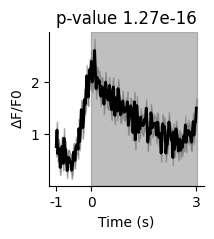

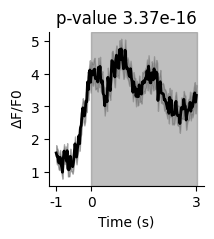

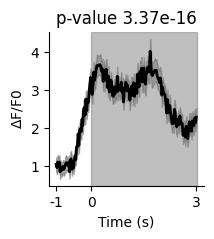

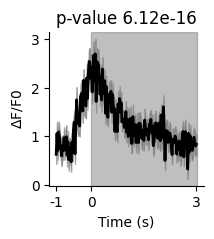

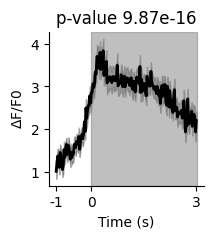

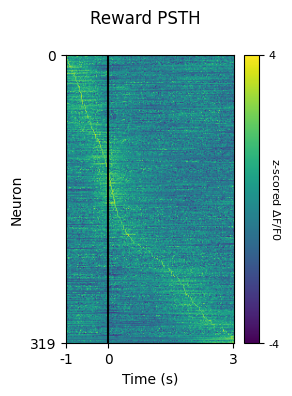

In [ ]:
# Plot reward PSTH for -1 to +3 s
long_reward_psth, long_average_reward_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, event_idx=session['reward_idx'], \
                                                            time_around=(-1,3))

neural_analysis_helpers.plot_psth_single_neurons(long_reward_psth, long_average_reward_psth, neurons=original_cell_idx[0:5], time_around=(-1,3), num_neurons=5, pvalues=pvalue[strongest_cell_idx[0:5]], zscoring=False, avg_only=True)

neural_analysis_helpers.plot_avg_psth(average_psth=long_average_reward_psth, event='Reward', zscoring=True, time_around=(-1,3))


/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/VR_ABCD/neural_analysis_helpers.py:267: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



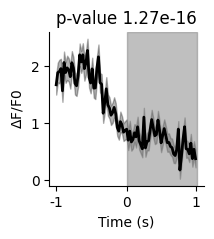

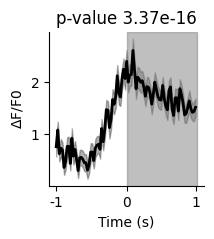

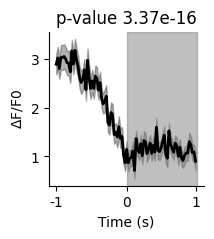

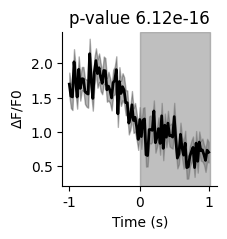

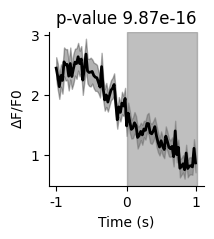

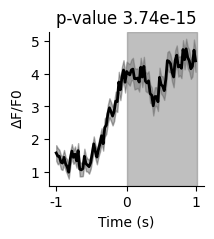

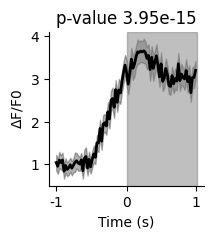

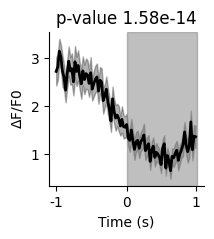

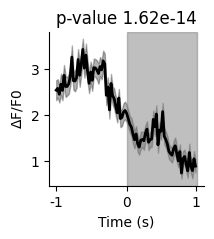

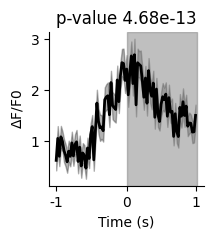

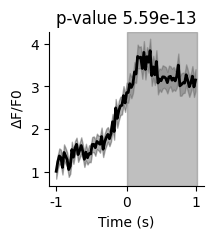

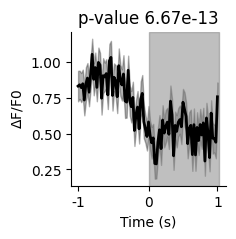

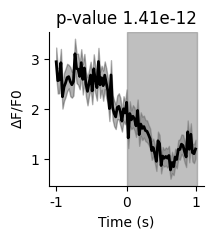

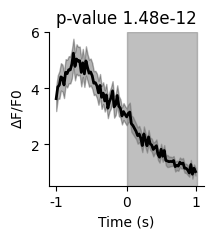

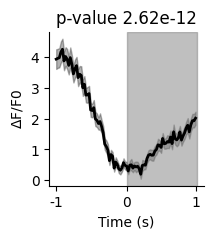

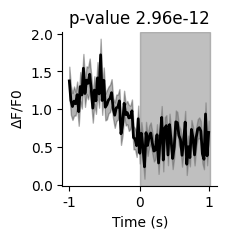

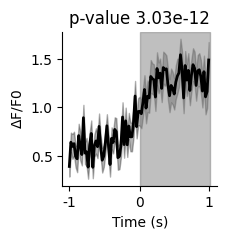

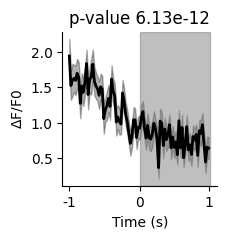

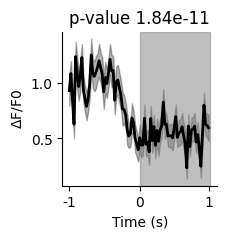

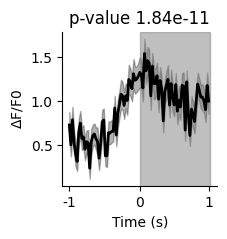

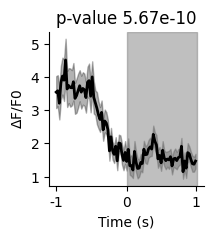

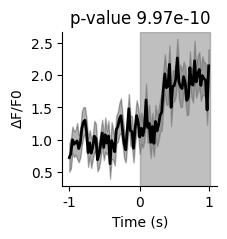

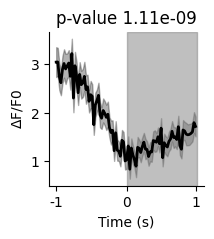

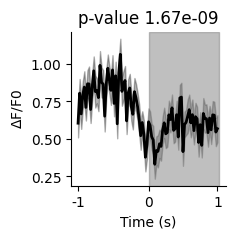

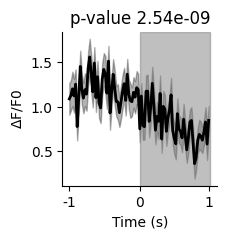

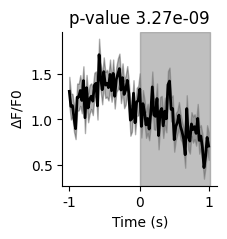

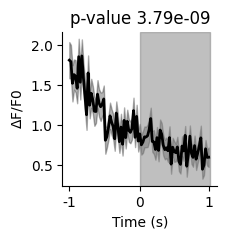

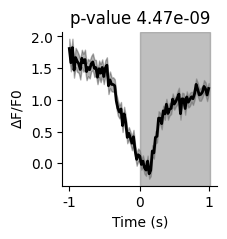

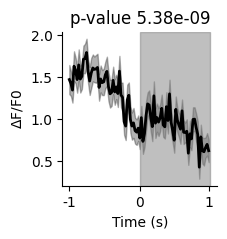

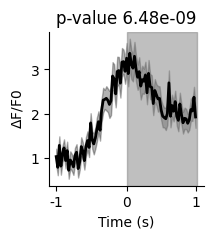

In [ ]:
# Test single neuron peri-reward activity
neural_analysis_helpers.plot_psth_single_neurons(reward_psth, average_reward_psth, neurons=strongest_cell_idx[0:30], time_around=time_around, num_neurons=len(strongest_cell_idx[0:30]), pvalues=pvalue[strongest_cell_idx[0:30]], zscoring=False, avg_only=True)

##### Reward-specific tuning

In [ ]:
if reload_results:

    if protocol_num >= 5:
        ABCD_goals = [1,2,3,4]
        ABCD_rewards_idx = {}
        reward_id_psth = {}
        average_reward_id_psth = {}
        significant_neurons_reward_id = {}
        pvalues_id = {}
        stat_id = {}

        for goal in ABCD_goals:

            # Find rewards by goal ID
            # ABCD_rewards_idx[goal] = np.array([session['reward_idx'][i] for i, idx in enumerate(rewarded_landmarks) \
            #                                 if session['all_lms'][idx] == goal])
            ABCD_rewards_idx[goal] = np.array([session['reward_idx'][i] for i, idx in enumerate(session['rewarded_landmarks']) \
                                            if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])

            # Get reward PSTH by goal ID 
            reward_id_psth[goal], average_reward_id_psth[goal] = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, \
                                                                        event_idx=ABCD_rewards_idx[goal], time_around=time_around)
            
            # Find neurons tuned to each reward by goal ID
            significant_neurons_reward_id[goal], stat_id[goal], pvalues_id[goal] = neural_analysis_helpers.get_tuned_neurons(reward_id_psth[goal], \
                                                                event=f'reward {goal}', time_around=time_around, plot_neurons=False)
            
        # Find neurons tuned to any reward
        all_significant_neurons_reward = np.unique(np.concatenate([significant_neurons_reward_id[goal] for goal in ABCD_goals]))
        print(f'{len(all_significant_neurons_reward)} neurons are tuned to any reward.')

        results_rewards['reward_id_psth'] = reward_id_psth
        results_rewards['average_reward_id_psth'] = average_reward_id_psth
        results_rewards['significant_neurons_reward_id'] = significant_neurons_reward_id
        results_rewards['all_significant_neurons_reward'] = all_significant_neurons_reward

    else:
        all_significant_neurons_reward = significant_neurons_reward
        results_rewards['all_significant_neurons_reward'] = all_significant_neurons_reward
        print('This does not make sense before T5.')

# TODO: fix signals for m3
if mouse == 'TAA0000061':
    all_significant_neurons_reward = np.arange(0, len(neurons_considered))
else:
    all_significant_neurons_reward = results_rewards['all_significant_neurons_reward']
    

39 neurons are tuned to reward 1.
40 neurons are tuned to reward 2.
41 neurons are tuned to reward 3.
35 neurons are tuned to reward 4.
100 neurons are tuned to any reward.


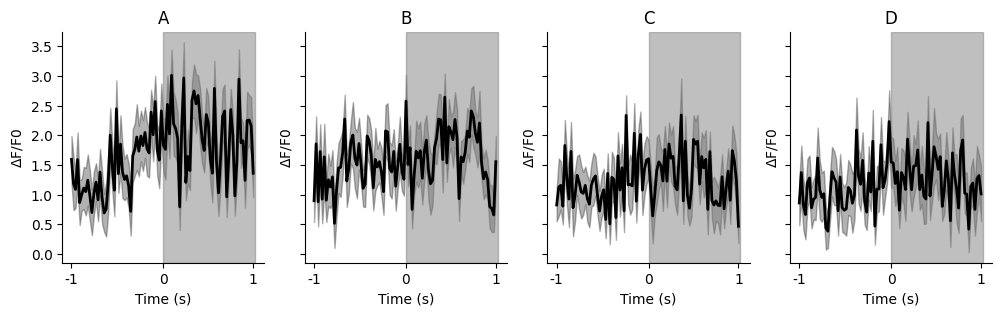

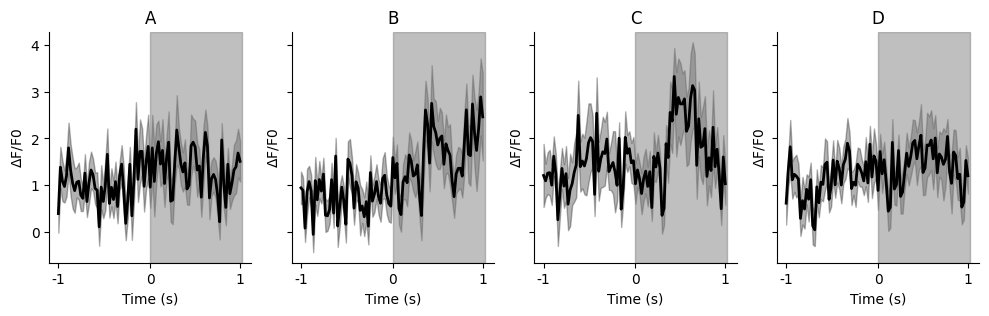

In [ ]:
# Plot stronest A-tuned only neuron
# Neurons tuned to goal A and not the rest 
neurons_A = np.setdiff1d(significant_neurons_reward_id[1], np.concatenate([significant_neurons_reward_id[2], significant_neurons_reward_id[3], significant_neurons_reward_id[4]]))

pvalues_id[1] = np.array(pvalues_id[1]).flatten()
strongest_cell_A_idx = np.argsort(pvalues_id[1][neurons_A])

fig, ax = plt.subplots(1, 4, figsize=(12,3), sharey=True)
titles = ['A','B','C','D']

for g, goal in enumerate(ABCD_goals):
    neural_analysis_helpers.plot_psth_single_neurons(reward_id_psth[goal], average_reward_id_psth[goal], neurons=neurons_A[strongest_cell_A_idx[0]], time_around=time_around, num_neurons=5, pvalues=None, zscoring=False, avg_only=True, axis=ax[g])
    ax[g].set_title(titles[g])

# Plot stronest B-tuned only neuron
# Neurons tuned to goal B and not the rest 
neurons_B = np.setdiff1d(significant_neurons_reward_id[2], np.concatenate([significant_neurons_reward_id[1], significant_neurons_reward_id[3], significant_neurons_reward_id[4]]))

pvalues_id[2] = np.array(pvalues_id[2]).flatten()
strongest_cell_B_idx = np.argsort(pvalues_id[2][neurons_B])

fig, ax = plt.subplots(1, 4, figsize=(12,3), sharey=True)
titles = ['A','B','C','D']

for g, goal in enumerate(ABCD_goals):
    neural_analysis_helpers.plot_psth_single_neurons(reward_id_psth[goal], average_reward_id_psth[goal], neurons=neurons_B[strongest_cell_B_idx[0]], time_around=time_around, num_neurons=5, pvalues=None, zscoring=False, avg_only=True, axis=ax[g])
    ax[g].set_title(titles[g])


##### Compare average reward PSTH map in rewarded vs non-goal landmark vs ‘test’ vs miss goal landmarks (because of high speed or no licking)

In [ ]:
# Get PSTHs for non-rewarded landmarks
if reload_results:

    conditions = ['rewarded', 'miss', 'non-goal', 'test']
    ids = [0,1,2,3]

    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    event_indices = {}

    for id in ids:
        if id == 0:
            event_indices[id] = session['reward_idx']
        elif id == 1:
            event_indices[id] = session['miss_rew_idx']
        elif id == 2:
            event_indices[id] = session['nongoal_rew_idx']
        elif id == 3:
            event_indices[id] = session['test_rew_idx']
            
    miss_psth, average_miss_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[1], time_around=time_around)

    nongoal_psth, average_nongoal_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[2], time_around=time_around)

    test_psth, average_test_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[3], time_around=time_around)

    results_rewards['miss_psth'] = miss_psth
    results_rewards['average_miss_psth'] = average_miss_psth
    results_rewards['nongoal_psth'] = nongoal_psth
    results_rewards['average_nongoal_psth'] = average_nongoal_psth
    results_rewards['test_psth'] = test_psth
    results_rewards['average_test_psth'] = average_test_psth 

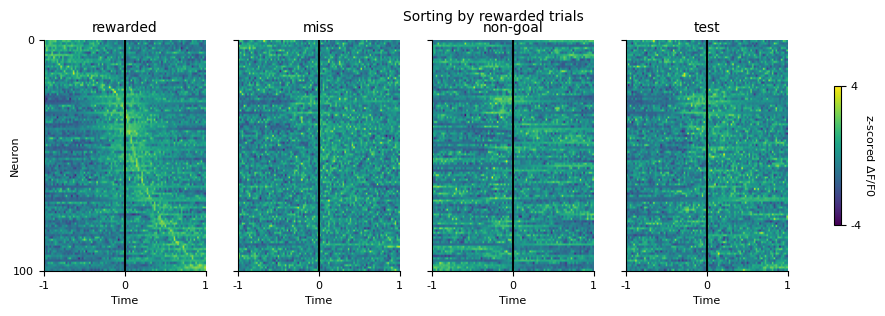

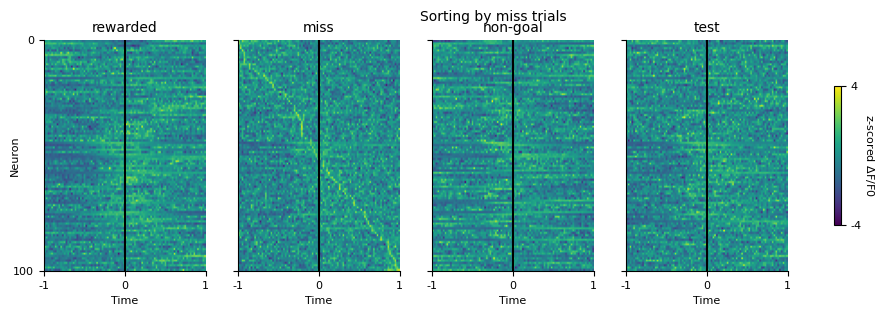

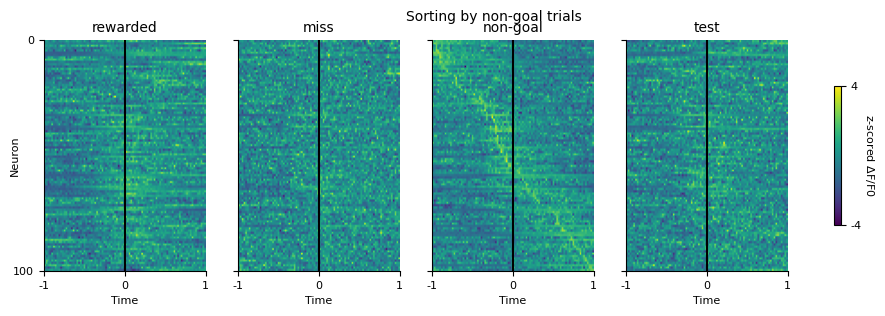

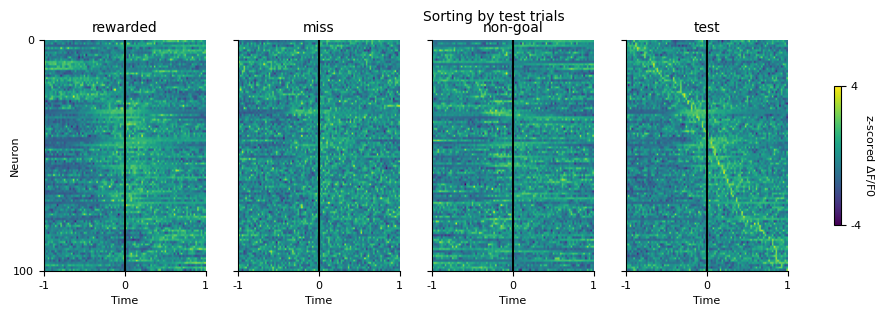

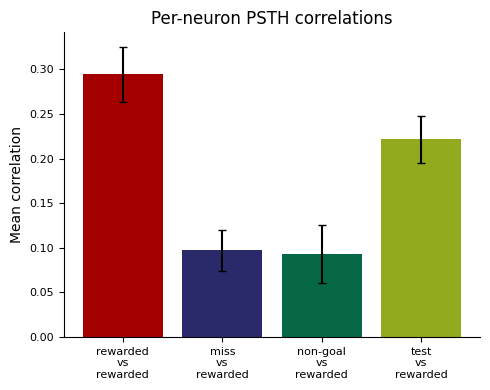

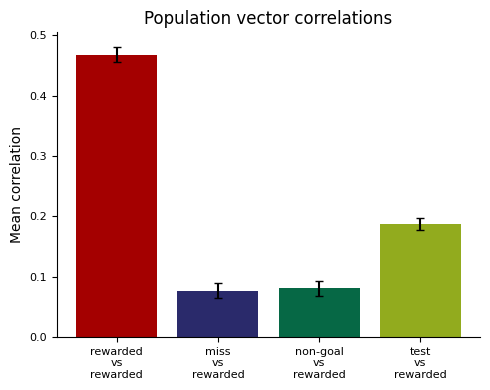

In [ ]:
# Get map correlations across conditions
if reload_results:

    psths = [reward_psth[all_significant_neurons_reward,:], miss_psth, nongoal_psth, test_psth]
    average_psths = [average_reward_psth[all_significant_neurons_reward,:], average_miss_psth, average_nongoal_psth, average_test_psth]

    neural_analysis_helpers.plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=save_plot, savepath=save_path, savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

    reward_corrs_neuron = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=False, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=save_plot, savepath=save_path, \
                            savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    reward_corrs_population = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=True, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=save_plot, savepath=save_path, \
                            savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    results_rewards['reward_corrs_neuron'] = reward_corrs_neuron
    results_rewards['reward_corrs_population'] = reward_corrs_population

##### Split T5 

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



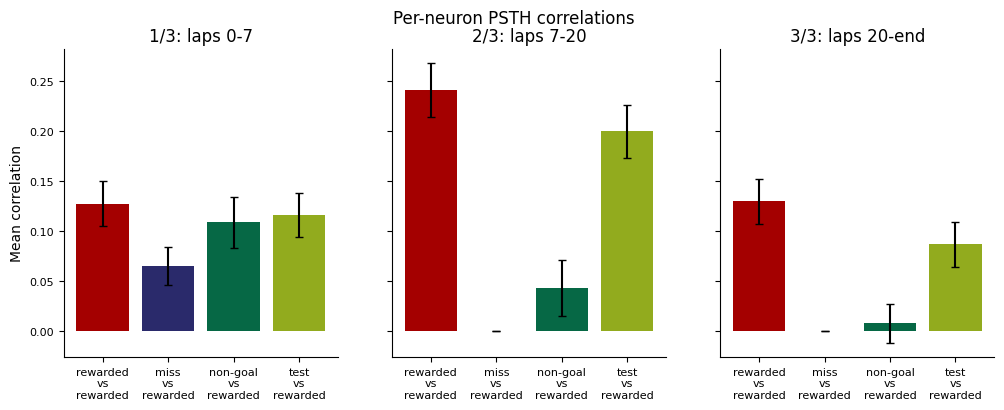

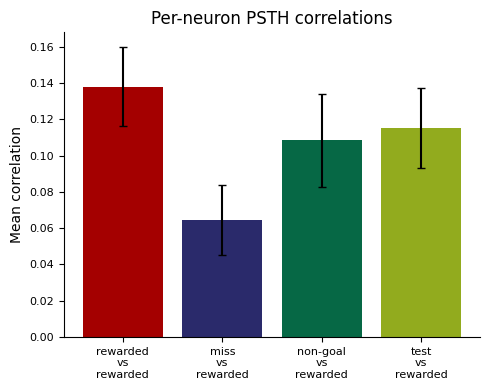

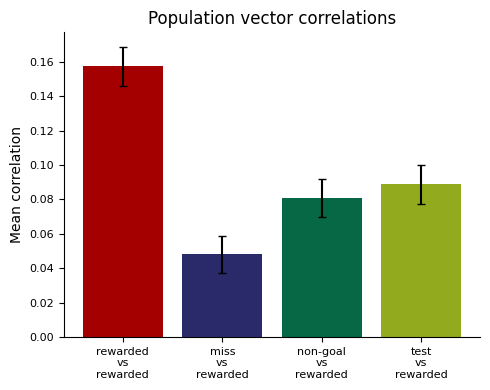

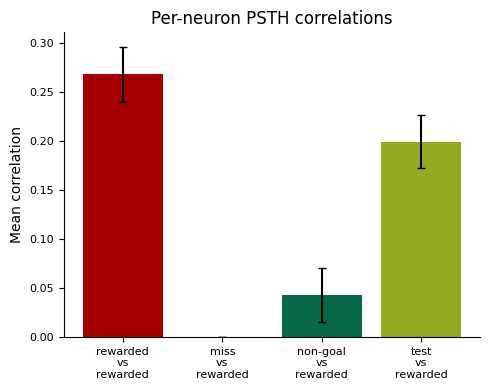

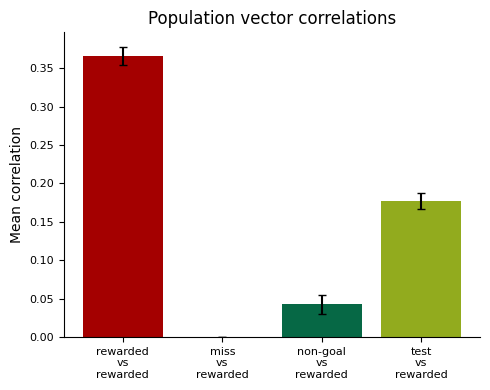

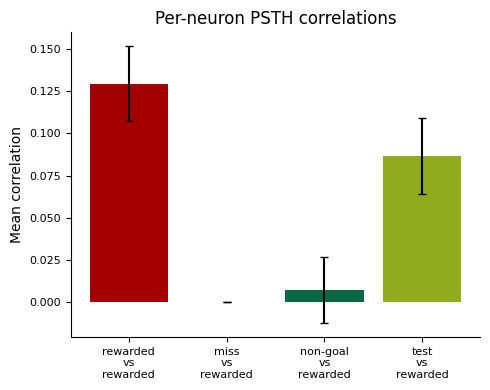

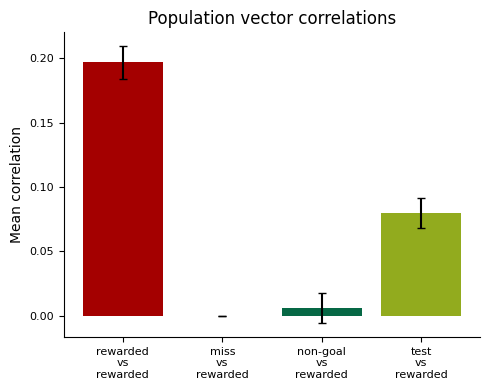

In [ ]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and mouse == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs_neuron = [[] for i in range(3)]
        split_corrs_population = [[] for i in range(3)]

        # Create T5 split figure 
        fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_reward_idx)
                                                                        if idx in event_indices[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   
                                
            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, \
                                                average_psths=split_average_psths, conditions=conditions, population=False, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=save_plot, savepath=save_path, \
                                savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
            split_corrs_population[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, \
                                                average_psths=split_average_psths, conditions=conditions, population=True, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[ids], save_plot=save_plot, savepath=save_path, \
                                savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
            _ = neural_analysis_helpers.get_map_correlation(psths=split_psths, \
                                                average_psths=split_average_psths, conditions=conditions, population=False, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[ids], ax=ax[i], save_plot=False, savepath=save_path, \
                                savedir='RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_T5splits')
        
        # Configure T5 split figure
        ax[0].set_ylabel('Mean correlation')
        ax[0].set_title('1/3: laps 0-7')
        ax[1].set_title('2/3: laps 7-20')
        ax[2].set_title('3/3: laps 20-end')
        fig.suptitle('Per-neuron PSTH correlations')

        # Save T5 split figure
        output_path = os.path.join(save_path, 'RewardFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, 'FiringMap_correlation_T5splits' + '.png'))


        results_rewards['split_corrs_neuron'] = split_corrs_neuron
        results_rewards['split_corrs_population'] = split_corrs_population

[11 18 31 36 38 45 59 61 62 65 66 69 76 81 91 92 93 97]


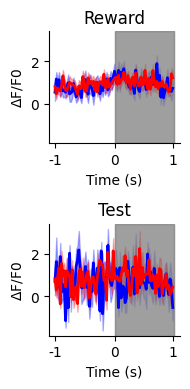

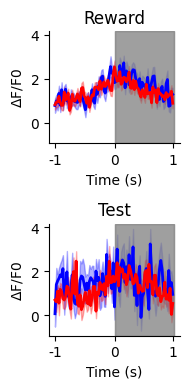

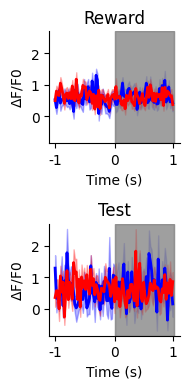

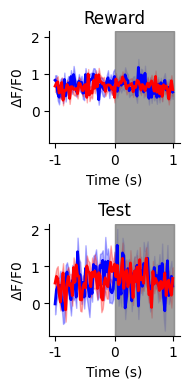

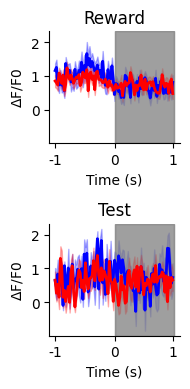

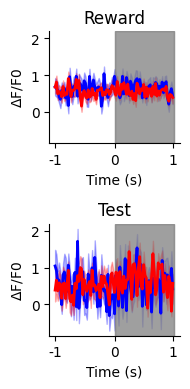

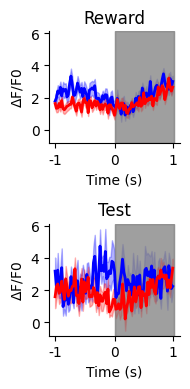

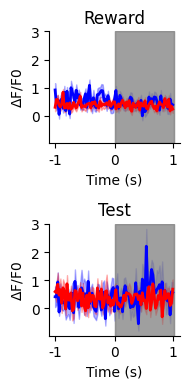

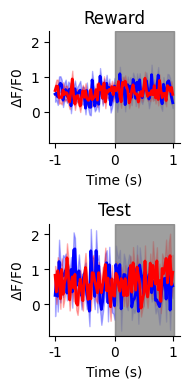

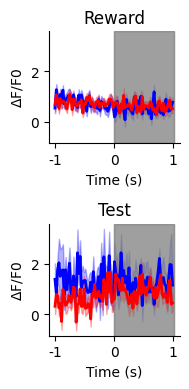

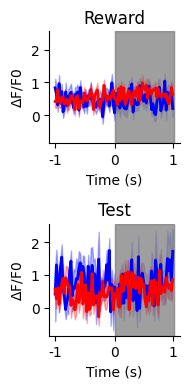

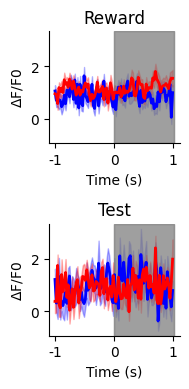

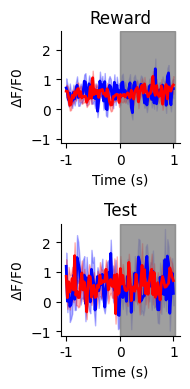

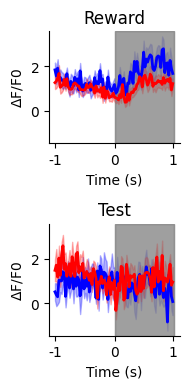

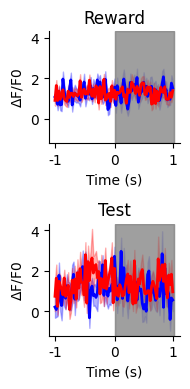

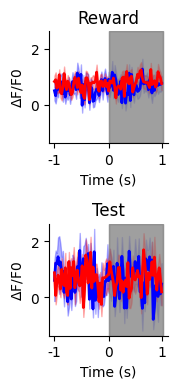

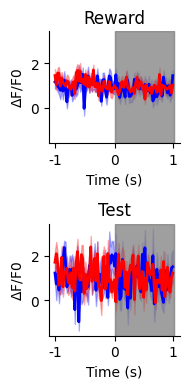

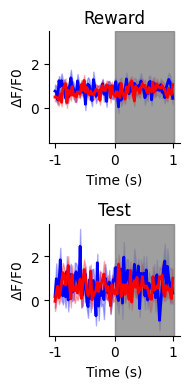

In [ ]:
# Are there single neurons that (i) increase in split-half correlation between rewards while they 
# (ii) decrease in correlation between test and reward and vice versa?
if protocol_num == 5 and mouse == 'TAA0000066':
    split_psths = {}
    split_average_psths = {}
    for i in range(3):
        split_psths[i] = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
        split_average_psths[i] = [np.mean(psth, axis=1) for psth in split_psths[i]]
   
    # Change in reward correlation between 2/3 and 3/3
    diff_rew_corr = []
    for n in range(len(all_significant_neurons_reward)):
        if (split_corrs_neuron[2][0][n] - split_corrs_neuron[1][0][n]) > 0:  # 3/3 - 2/3 reward-reward corr
            diff_rew_corr.append(n)

    # Change in reward-test correlation between 2/3 and 3/3   
    diff_rew_test_corr = []
    for n in range(len(all_significant_neurons_reward)):
        if (split_corrs_neuron[2][3][n] - split_corrs_neuron[1][3][n]) < 0:  # 3/3 - 2/3 test-reward corr
            diff_rew_test_corr.append(n)

    common_neurons = np.intersect1d(diff_rew_corr, diff_rew_test_corr)
    print(common_neurons)
    
    for n in common_neurons:
        fig, ax = plt.subplots(2, 1, figsize=(2,4), sharey=True)
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[2][0], split_average_psths[2][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[0])
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[1][0], split_average_psths[1][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[0])
        ax[0].set_title('Reward')
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[2][3], split_average_psths[2][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[1])
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[1][3], split_average_psths[1][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[1])
        ax[1].set_title('Test')
        # plt.legend()  # TODO: fix legend 
        plt.tight_layout()
     

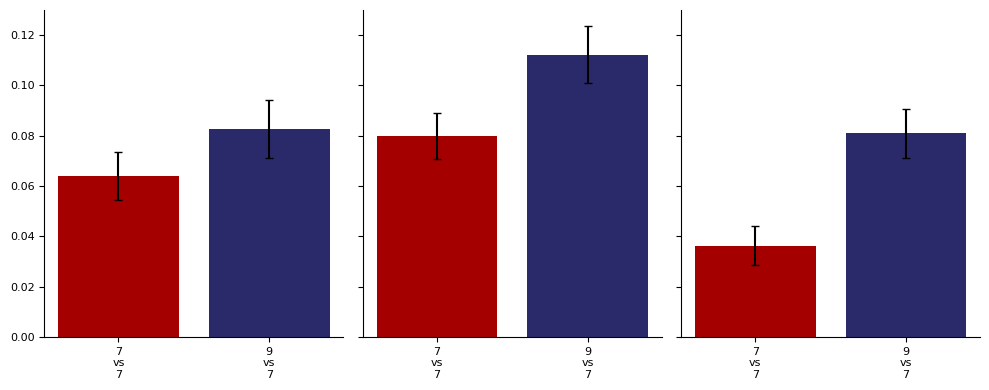

In [ ]:
# Split T5 according to landmark (10 x 3). NOTE all neurons are used.
if protocol_num == 5 and mouse == 'TAA0000066':
    split_rew_idx = [[] for _ in range(3)]
    split_corrs_neuron = [[] for _ in range(3)]

    fig, ax = plt.subplots(1, 3, figsize=(10,4), sharey=True)
    for i in range(3):
        if i == 0:
            trials = np.arange(0, 70)   # laps 0-7
        elif i == 1:
            trials = np.arange(70, 200)     # laps 7-20
        elif i == 2:
            trials = np.arange(200, num_lms)   # laps 20-end

        if i == 0:
            split_rew_idx[i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_reward_idx)
                                                            if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
        elif i == 1:
            split_rew_idx[i] = np.arange(len(split_rew_idx[i-1]), len(split_rew_idx[i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
        elif i == 2:
            split_rew_idx[i] = np.arange(sum(len(split_rew_idx[j]) for j in range(i)), sum(len(split_rew_idx[j]) for j in range(i)) + 
                                            len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                        if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
        
        landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=all_reward_idx[split_rew_idx[i]], \
                                                                num_landmarks=session['num_landmarks'], time_around=time_around)
        landmark_psth = np.array(landmark_psth)
        average_landmark_psth = np.array(average_landmark_psth)

        # Get the landmark indices
        landmark_indices_6 = np.arange(6, landmark_psth.shape[1], 10)
        landmark_indices_8 = np.arange(8, landmark_psth.shape[1], 10)

        # Extract every 10th PSTH starting from 6 and 8
        psths_from_6 = [landmark_psth[:, idx, :] for idx in landmark_indices_6]
        psths_from_8 = [landmark_psth[:, idx, :] for idx in landmark_indices_8]

        psths_from_6 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_6], axis=1)
        psths_from_8 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_8], axis=1)

        # Compare 7th and 9th landmarks
        psths = [psths_from_6, psths_from_8]
        average_psths = [average_landmark_psth[:,6,:], average_landmark_psth[:,8,:]]
        split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=psths, \
                                                average_psths=average_psths, conditions=['7','9'], population=False, \
                            zscoring=True, reference=0, ax=ax[i], save_plot=True, color_scheme=hfs_palette[0:2], savepath=save_path, \
                                savedir='RewardFiringMap_nongoal_7-9_RewardTunedNeurons', filename=f'FiringMap_correlation')
    
    plt.tight_layout()



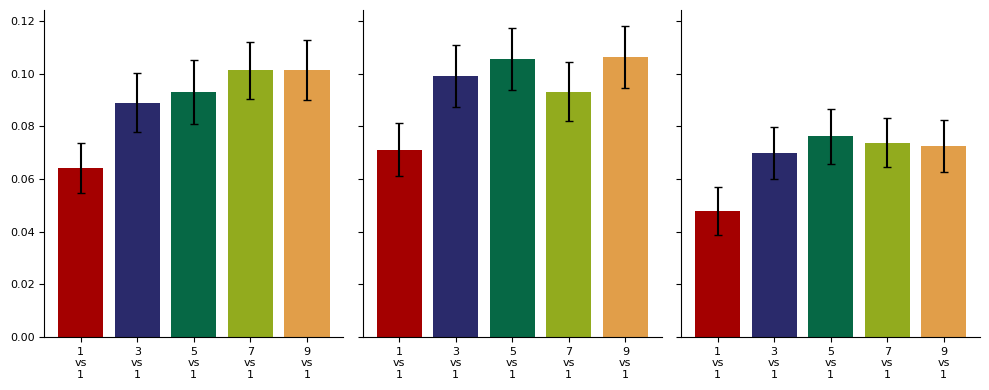

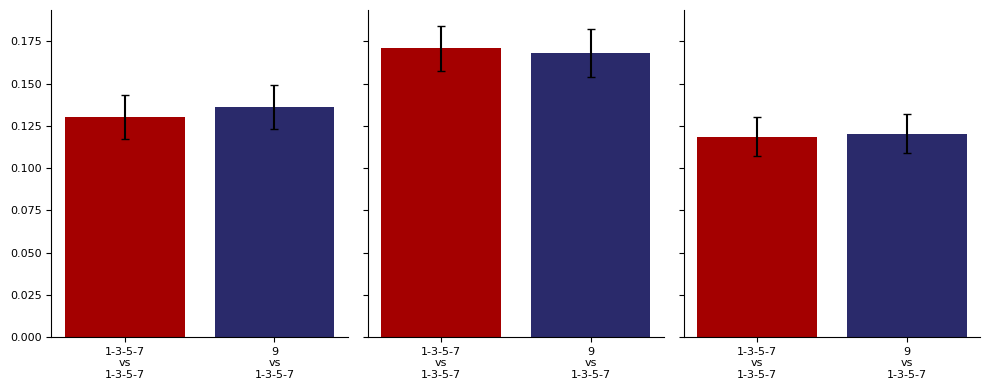

In [ ]:
# Split T5 according to landmark (10 x 3). NOTE all neurons are used. 
if protocol_num == 5 and mouse == 'TAA0000066':
    split_rew_idx = [[] for _ in range(3)]
    split_corrs_neuron = [[] for _ in range(3)]

    fig1, ax = plt.subplots(1, 3, figsize=(10,4), sharey=True)
    fig2, ax2 = plt.subplots(1, 3, figsize=(10,4), sharey=True)
    for i in range(3):
        if i == 0:
            trials = np.arange(0, 70)   # laps 0-7
        elif i == 1:
            trials = np.arange(70, 200)     # laps 7-20
        elif i == 2:
            trials = np.arange(200, num_lms)   # laps 20-end

        if i == 0:
            split_rew_idx[i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_reward_idx)
                                                            if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
        elif i == 1:
            split_rew_idx[i] = np.arange(len(split_rew_idx[i-1]), len(split_rew_idx[i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                                if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
        elif i == 2:
            split_rew_idx[i] = np.arange(sum(len(split_rew_idx[j]) for j in range(i)), sum(len(split_rew_idx[j]) for j in range(i)) + 
                                            len(np.array([idx for i, idx in enumerate(all_reward_idx) 
                                                        if ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
        
        landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=all_reward_idx[split_rew_idx[i]], \
                                                                num_landmarks=session['num_landmarks'], time_around=time_around)
        landmark_psth = np.array(landmark_psth)
        average_landmark_psth = np.array(average_landmark_psth)

        # Get the landmark indices
        landmark_indices_0 = np.arange(0, landmark_psth.shape[1], 10)
        landmark_indices_2 = np.arange(2, landmark_psth.shape[1], 10)
        landmark_indices_4 = np.arange(4, landmark_psth.shape[1], 10)
        landmark_indices_6 = np.arange(6, landmark_psth.shape[1], 10)
        landmark_indices_8 = np.arange(8, landmark_psth.shape[1], 10)

        # Extract every 10th non-goal PSTH starting  
        psths_from_0 = [landmark_psth[:, idx, :] for idx in landmark_indices_0]
        psths_from_2 = [landmark_psth[:, idx, :] for idx in landmark_indices_2]
        psths_from_4 = [landmark_psth[:, idx, :] for idx in landmark_indices_4]
        psths_from_6 = [landmark_psth[:, idx, :] for idx in landmark_indices_6]
        psths_from_8 = [landmark_psth[:, idx, :] for idx in landmark_indices_8]

        psths_from_0 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_0], axis=1)
        psths_from_2 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_2], axis=1)
        psths_from_4 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_4], axis=1)
        psths_from_6 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_6], axis=1)
        psths_from_8 = np.stack([landmark_psth[:, idx, :] for idx in landmark_indices_8], axis=1)

        # Compare all non-goal landmarks
        psths = [psths_from_0, psths_from_2, psths_from_4, psths_from_6, psths_from_8]
        average_psths = [average_landmark_psth[:,0,:], average_landmark_psth[:,2,:], average_landmark_psth[:,4,:], average_landmark_psth[:,6,:], average_landmark_psth[:,8,:]]
        split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=psths, \
                                                average_psths=average_psths, conditions=['1','3','5','7','9'], population=False, \
                            zscoring=True, reference=0, ax=ax[i], save_plot=False, color_scheme=hfs_palette[0:5], savepath=save_path, \
                                savedir='RewardFiringMap_nongoal_1-3-5-7-9_RewardTunedNeurons', filename=f'FiringMap_correlation')

        # Compare first 4 and last non-goal landmarks 
        psths_train = np.concatenate([psths_from_0, psths_from_2, psths_from_4, psths_from_6], axis=1)
        psths = [psths_train, psths_from_8]
        average_psths = [np.mean(psths_train, axis=1), average_landmark_psth[:,8,:]]
        split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=psths, \
                                                average_psths=average_psths, conditions=['1-3-5-7','9'], population=False, \
                            zscoring=True, reference=0, ax=ax2[i], save_plot=False, color_scheme=hfs_palette[0:2], savepath=save_path, \
                                savedir='RewardFiringMap_nongoal_avg1-3-5-7-9_RewardTunedNeurons', filename=f'FiringMap_correlation')
    
    fig1.tight_layout()
    fig2.tight_layout()


In [ ]:
# Get PSTHs for non-rewarded landmarks using all neurons
if reload_results:

    conditions = ['rewarded', 'miss', 'non-goal', 'test']
    ids = [0,1,2,3]

    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    event_indices = {}

    for id in ids:
        if id == 0:
            event_indices[id] = session['reward_idx']
        elif id == 1:
            event_indices[id] = session['miss_rew_idx']
        elif id == 2:
            event_indices[id] = session['nongoal_rew_idx']
        elif id == 3:
            event_indices[id] = session['test_rew_idx']
            
    miss_psth_all_neurons, average_miss_psth_all_neurons = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, \
                                                                    event_idx=event_indices[1], time_around=time_around)

    nongoal_psth_all_neurons, average_nongoal_psth_all_neurons = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, \
                                                                    event_idx=event_indices[2], time_around=time_around)

    test_psth_all_neurons, average_test_psth_all_neurons = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, \
                                                                    event_idx=event_indices[3], time_around=time_around)


/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



[  9  20  25  33  36  40  41  42  49  51  52  57  59  61  64  69  70  71
  73  76  81  90  95 103 107 117 127 128 131 138 145 148 158 168 174 175
 190 197 199 214 232 239 241 243 244 248 255 264 269 274 275 284 286 288
 291 303 311 314 318]


/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_16393/2800989227.py:28: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



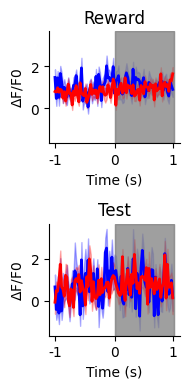

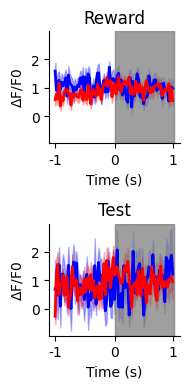

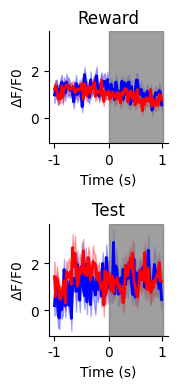

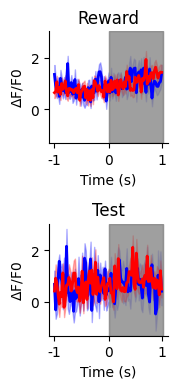

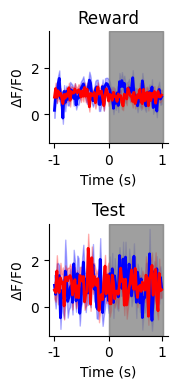

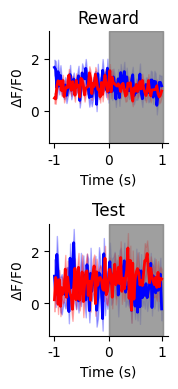

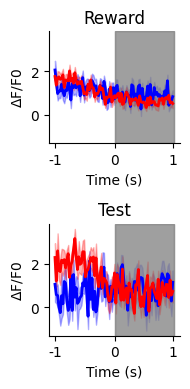

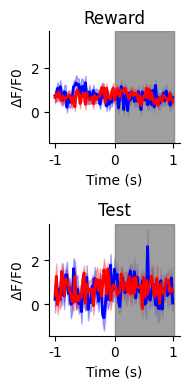

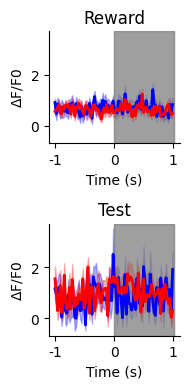

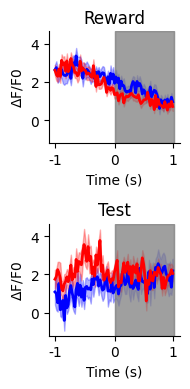

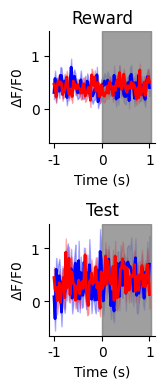

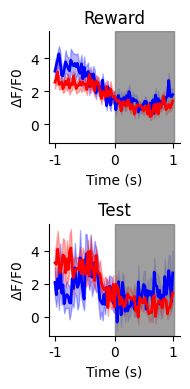

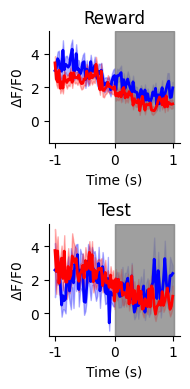

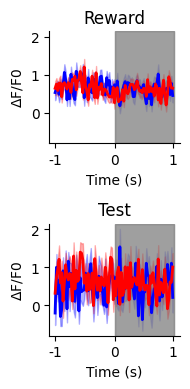

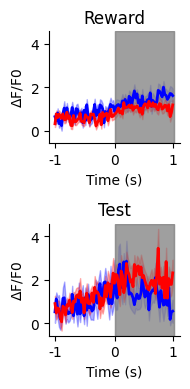

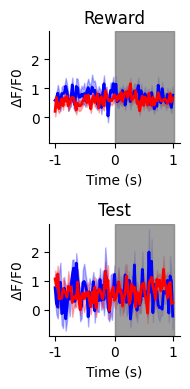

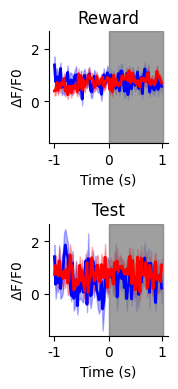

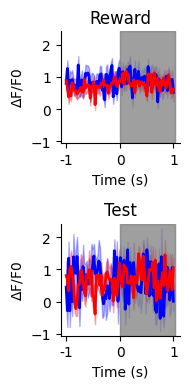

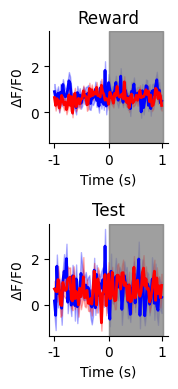

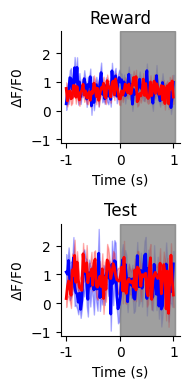

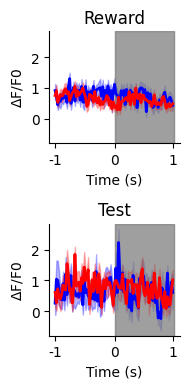

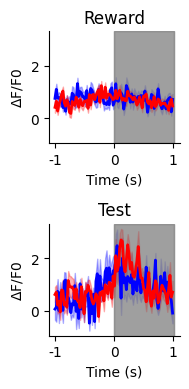

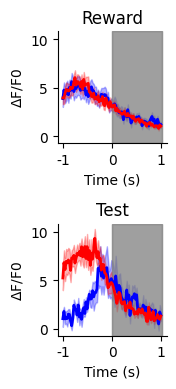

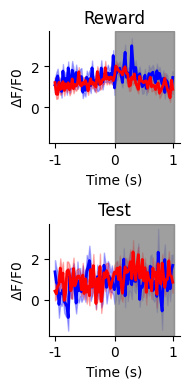

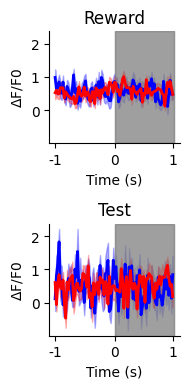

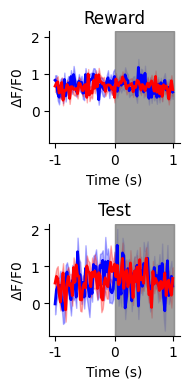

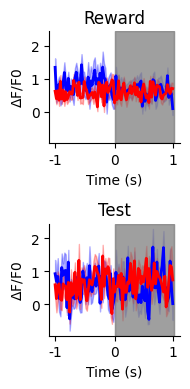

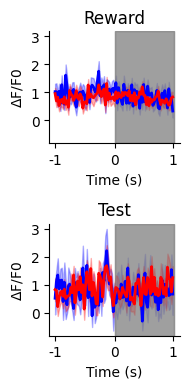

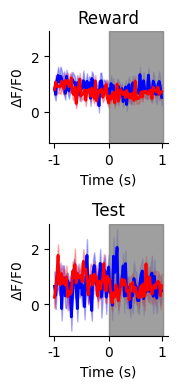

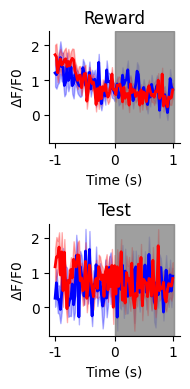

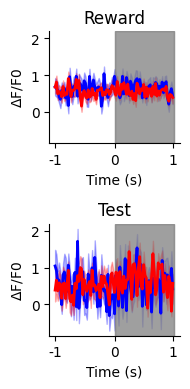

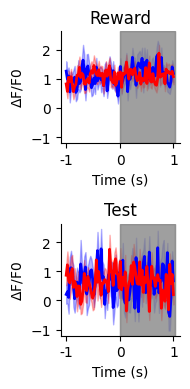

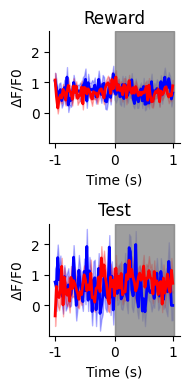

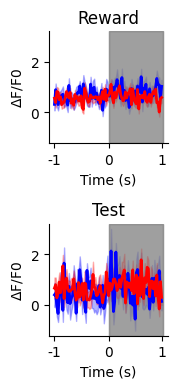

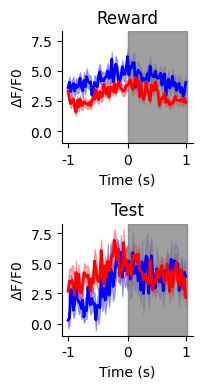

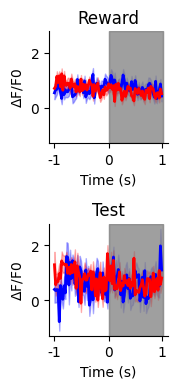

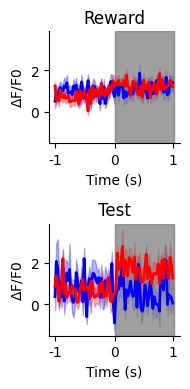

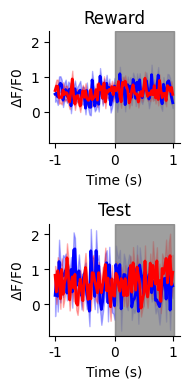

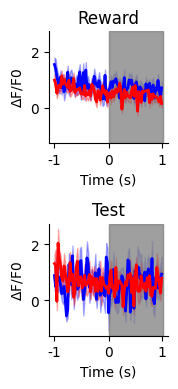

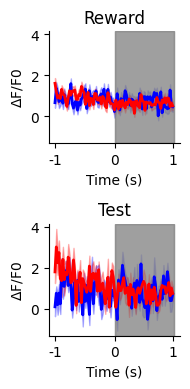

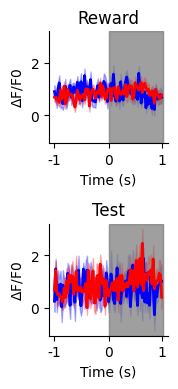

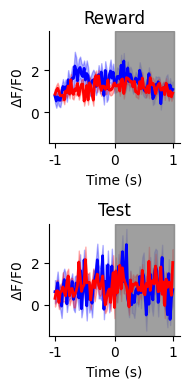

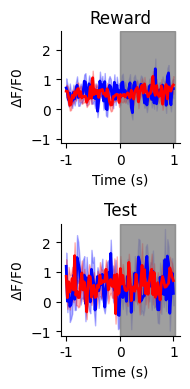

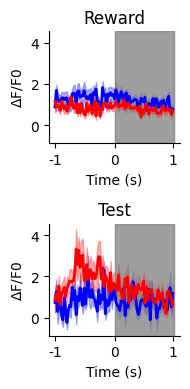

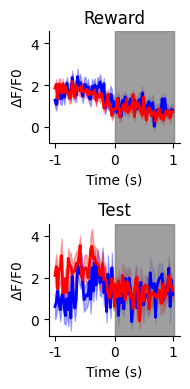

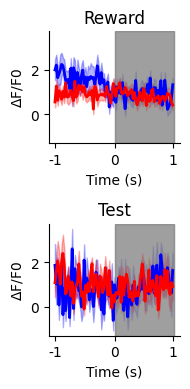

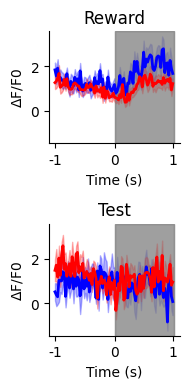

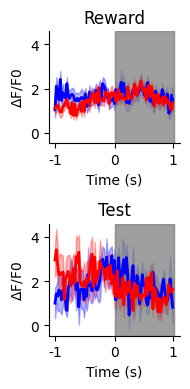

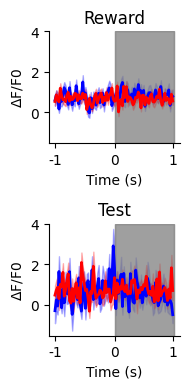

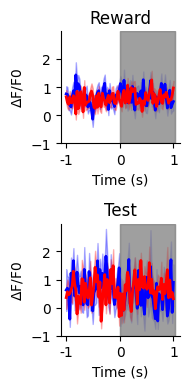

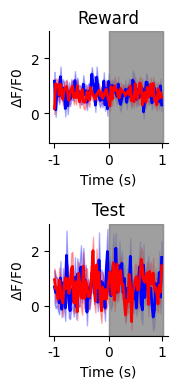

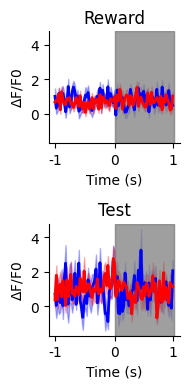

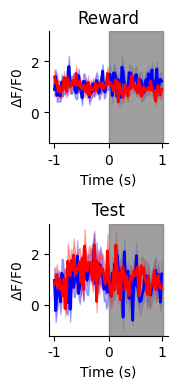

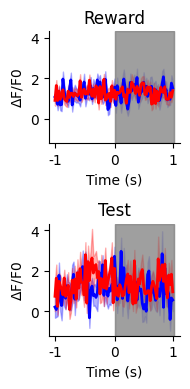

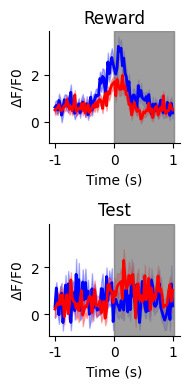

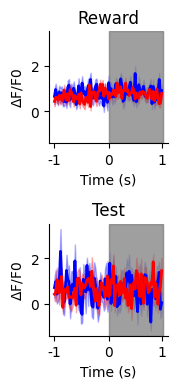

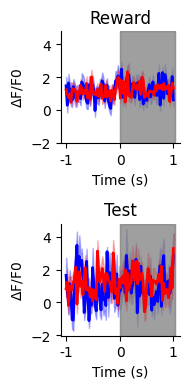

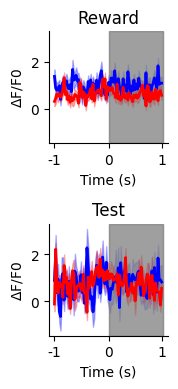

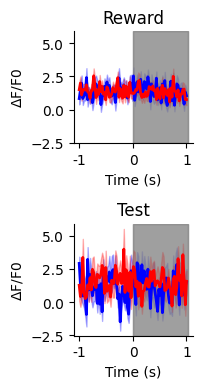

In [ ]:
# Are there single neurons that (i) change response amplitude to reward in alternation (2/3) vs discrimination (3/3)?
if protocol_num == 5 and mouse == 'TAA0000066':
    ids = [0,1,2,3]
    psths = [reward_psth, miss_psth_all_neurons, nongoal_psth_all_neurons, test_psth_all_neurons]

    split_psths = {}
    split_average_psths = {}
    for i in range(3):
        split_psths[i] = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
        split_average_psths[i] = [np.mean(psth, axis=1) for psth in split_psths[i]]  # num_splits x num_conditions x num_neurons x num_timebins

    # Change in reward amplitude between 2/3 and 3/3
    diff_rew_amplitude = []
    for n in range(len(neurons_considered)):
        if (np.mean(split_average_psths[2][0][n]) - np.mean(split_average_psths[1][0][n])) > 0:  # 3/3 - 2/3 reward-reward amplitude
            diff_rew_amplitude.append(n)

    # Change in test amplitude between 2/3 and 3/3   
    diff_test_amplitude = []
    for n in range(len(neurons_considered)):
        if (np.mean(split_average_psths[2][3][n]) - np.mean(split_average_psths[1][3][n])) < 0:  # 3/3 - 2/3 test-test amplitude
            diff_test_amplitude.append(n)

    common_neurons = np.intersect1d(diff_rew_amplitude, diff_test_amplitude)
    print(common_neurons)
    
    for n in common_neurons:
        fig, ax = plt.subplots(2, 1, figsize=(2,4), sharey=True)
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[2][0], split_average_psths[2][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[0])
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[1][0], split_average_psths[1][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[0])
        ax[0].set_title('Reward')
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[2][3], split_average_psths[2][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[1])
        neural_analysis_helpers.plot_psth_single_neurons(split_psths[1][3], split_average_psths[1][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[1])
        ax[1].set_title('Test')
        # plt.legend()  # TODO: fix legend 
        plt.tight_layout()

In [ ]:
# Are there single neurons that (i) change response amplitude to reward in alternation (2/3) vs discrimination (3/3) before t=0?
if protocol_num == 5 and mouse == 'TAA0000066':
    ids = [0,1,2,3]
    psths = [reward_psth, miss_psth_all_neurons, nongoal_psth_all_neurons, test_psth_all_neurons]

    split_psths = {}
    split_average_psths = {}
    for i in range(3):
        split_psths[i] = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
        split_average_psths[i] = [np.mean(psth, axis=1) for psth in split_psths[i]]  # num_splits x num_conditions x num_neurons x num_timebins

    half_timebins = int(np.round(len(split_average_psths[2][0][n]) / 2))
    # print(half_timebins)

    # Change in reward amplitude between 2/3 and 3/3
    diff_rew_amplitude = []
    for n in range(len(neurons_considered)):
        if (np.mean(split_average_psths[2][0][n:half_timebins+1]) - np.mean(split_average_psths[1][0][n:half_timebins+1])) > 0:  # 3/3 - 2/3 reward-reward amplitude
            diff_rew_amplitude.append(n)

    # Change in test amplitude between 2/3 and 3/3   
    diff_test_amplitude = []
    for n in range(len(neurons_considered)):
        if (np.mean(split_average_psths[2][3][n,0:half_timebins+1]) - np.mean(split_average_psths[1][3][n,0:half_timebins+1])) < 0:  # 3/3 - 2/3 test-test amplitude
            diff_test_amplitude.append(n)

    common_neurons = np.intersect1d(diff_rew_amplitude, diff_test_amplitude)
    uncommon_neurons = np.setdiff1d(np.arange(0,len(neurons_considered)), diff_test_amplitude)
    # common_neurons = diff_test_amplitude
    
    # for n in common_neurons:
    #     fig, ax = plt.subplots(2, 1, figsize=(2,4), sharey=True)
    #     plot_psth_single_neurons(split_psths[2][0], split_average_psths[2][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[0])
    #     plot_psth_single_neurons(split_psths[1][0], split_average_psths[1][0], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[0])
    #     ax[0].set_title('Reward')
    #     plot_psth_single_neurons(split_psths[2][3], split_average_psths[2][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='blue', axis=ax[1])
    #     plot_psth_single_neurons(split_psths[1][3], split_average_psths[1][3], n, time_around=time_around, num_neurons=1, avg_only=True, zscoring=False, color='red', axis=ax[1])
    #     ax[1].set_title('Test')
    #     # plt.legend()  # TODO: fix legend 
    #     plt.tight_layout()

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/Users/athinaapostolelli/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



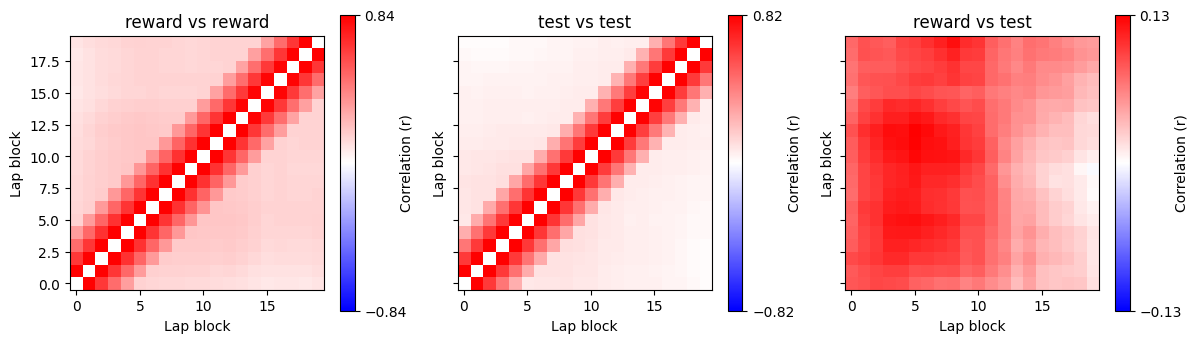

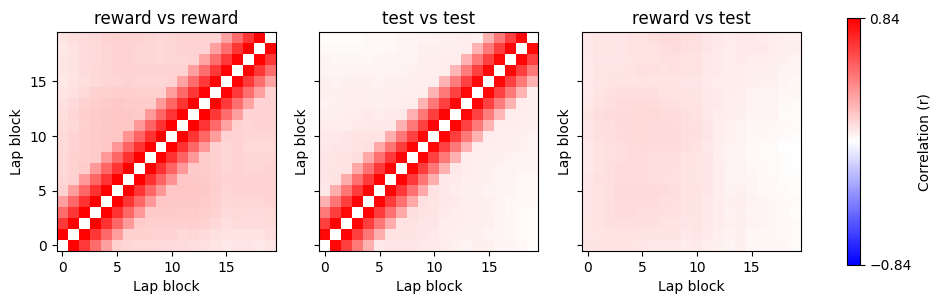

In [ ]:
# Sliding window across T5 reward and test correlations
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)
    ABCD_goals = [1,2,3,4]
    all_reward_idx = np.sort(np.concatenate([session['reward_idx'], session['miss_rew_idx'], session['nongoal_rew_idx'], session['test_rew_idx']]))

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=session['num_landmarks'], time_around=time_around)
         
    window_size = 5     # laps 
    
    # Get rolling reward avg
    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    # TODO: fix window size?
    # psths_considered = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, rew_idx[goal][i]:rew_idx[goal][i+window_size]:session['num_landmarks'], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling test avg
    valid_test_indices = np.array([idx for idx in session['test_idx'] if (idx > session['rewarded_landmarks'][0] and idx < session['rewarded_landmarks'][-1]+3)])
    num_windows = int(len(valid_test_indices - window_size + 1))
    rolling_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_test_psth[:, i, :] = np.mean(landmark_psth[:, valid_test_indices[i]:valid_test_indices[i+window_size]:session['num_landmarks'], :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['reward', 'test']
    average_psths = [rolling_avg_reward_psth, rolling_avg_test_psth]

    # within_corrs, across_corrs, condition_pairs = get_rolling_map_correlation(average_psths, conditions, population=False, \
    #                                                                           zscoring=True, color_scheme=None, ax=None, save_plot=False, \
    #                                                                             savepath='', savedir='', filename='')
    
    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

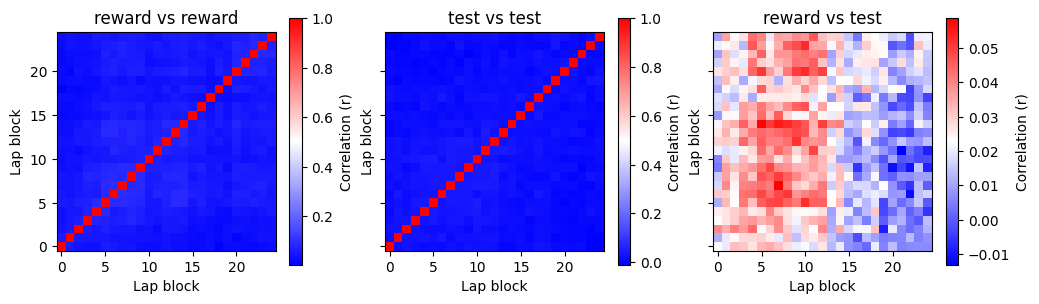

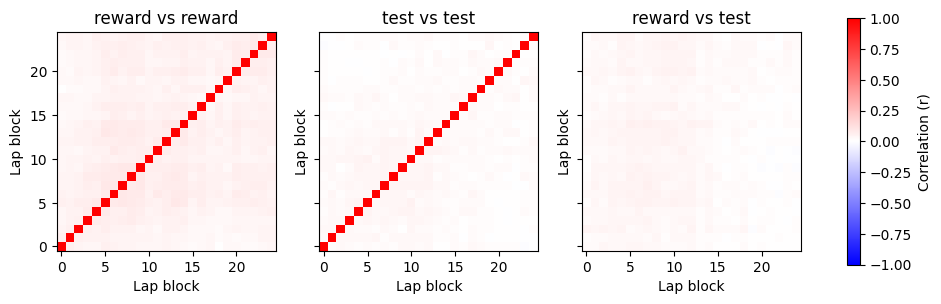

In [ ]:
# Get the pairwise correlations of laps
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)

    rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]])
        
        num_windows = len(rew_idx[goal]) 

    first_lap = int(np.floor(rew_idx[1][0] // 10))

    lap_avg_reward_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        psths_considered = np.stack([landmark_psth[:, rew_idx[goal][i], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x num_windows * num_goals x num_timebins

        lap_avg_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    lap_avg_test_psth = np.zeros((landmark_psth.shape[0], num_windows, landmark_psth.shape[2])) 
    for i in range(num_windows):
        lap_avg_test_psth[:, i, :] = landmark_psth[:, valid_test_indices[i], :]

# Get correlation matrix of average psths in rolling lap blocks
conditions = ['reward', 'test']
average_psths = [lap_avg_reward_psth, lap_avg_test_psth]

similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

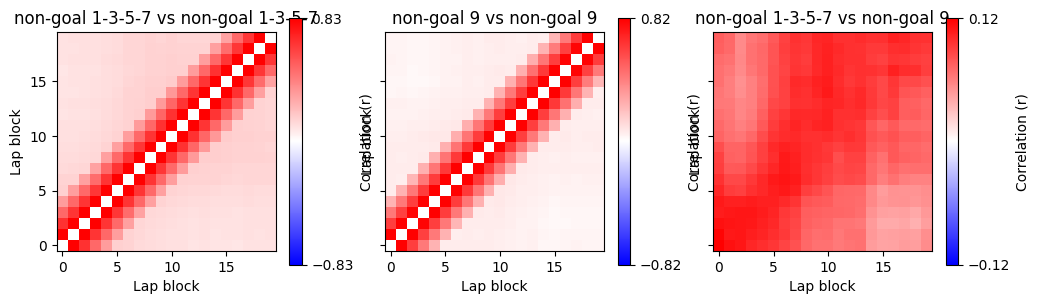

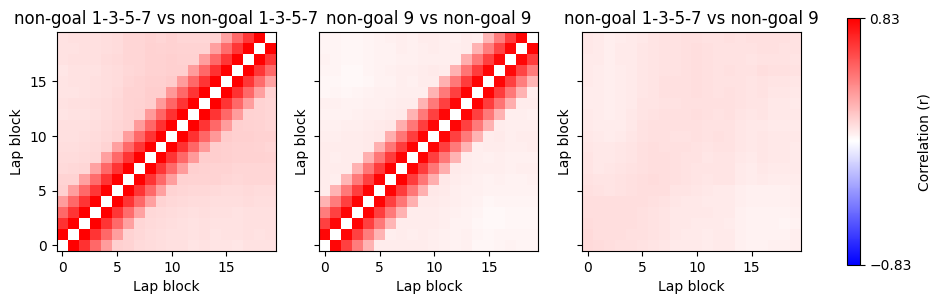

In [ ]:
# Sliding window over laps of pairwise non-goal correlations 
if protocol_num == 5 and mouse == 'TAA0000066':
    num_lms_considered = np.round((num_lms // 10) * 10)
    num_laps = int(num_lms_considered / 10)

    landmark_psth, average_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=all_reward_idx[:num_lms_considered], \
                                                                num_landmarks=session['num_landmarks'], time_around=time_around)
         
    window_size = 5     # laps 

    non_goal_idx = {}    
    for g, non_goal in enumerate([0,2,4,6,8]):
        non_goal_idx[non_goal] = np.array([idx for idx in session['non_goals_idx'] \
                                if session['all_lms'][idx] == session['non_goal_landmark_id'][g]
                                and (idx < num_lms_considered)])

    # Get rolling non-goal avg
    # psths_considered = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_0246_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 
    rolling_avg_8_psth = np.zeros((landmark_psth.shape[0], num_windows-window_size, landmark_psth.shape[2])) 

    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([landmark_psth[:, non_goal_idx[non_goal][i]:non_goal_idx[non_goal][i+window_size]:session['num_landmarks'], :] for non_goal in [0,2,4,6]], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_0246_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        rolling_avg_8_psth[:, i, :] = np.mean(landmark_psth[:, non_goal_idx[8][i]:non_goal_idx[8][i+window_size]:session['num_landmarks'], :], axis=1)
        # shape: num_neurons x num_windows x num_timebins

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['non-goal 1-3-5-7', 'non-goal 9']
    average_psths = [rolling_avg_0246_psth, rolling_avg_8_psth]

    # within_corrs, across_corrs, condition_pairs = get_rolling_map_correlation(average_psths, conditions, population=False, \
    #                                                                           zscoring=True, color_scheme=None, ax=None, save_plot=False, \
    #                                                                             savepath='', savedir='', filename='')
    
    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

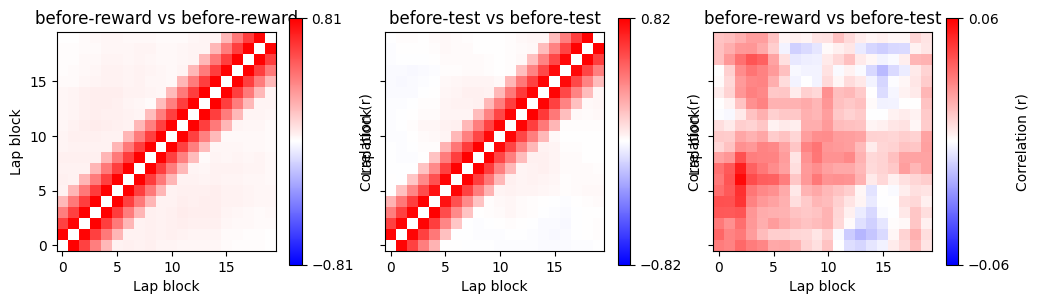

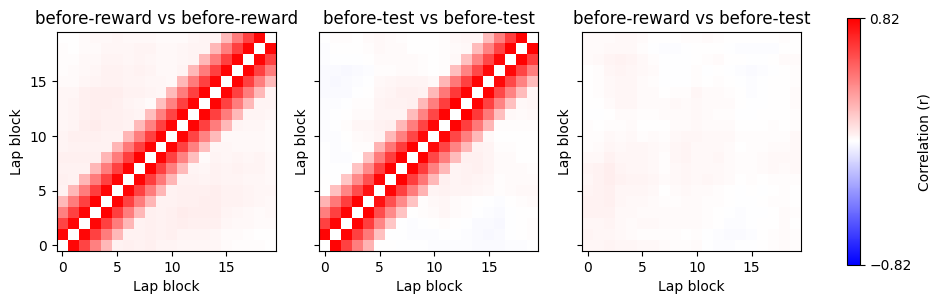

In [ ]:
# Sliding window over laps of pairwise between landmark correlations 
if protocol_num == 5 and mouse == 'TAA0000066':

    # Define 'events' between landmarks 
    num_lms_considered = int(np.round((num_lms // 10) * 10))
    num_laps = int(num_lms_considered / session['num_landmarks'])

    before_lm = []
    after_lm = []
    for i in np.arange(session['num_landmarks'], num_lms_considered):  # skipping first lap 
        before_lm.append(len(np.arange(lm_exit_idx[i-1], lm_entry_idx[i])))
        after_lm.append(len(np.arange(lm_exit_idx[i], lm_entry_idx[i+1])))

    midpoints_before = np.rint(np.array(before_lm) / 2).astype(int)
    midpoints_after = np.rint(np.array(after_lm) / 2).astype(int)
    min_frames_around = np.min([midpoints_before, midpoints_after])
    # print(min_frames_around)

    new_time_around = min_frames_around / funcimg_frame_rate  # new time around to avoid overlaps with landmark 

    event_indices = []
    for i, idx in enumerate(np.arange(session['num_landmarks'], num_lms_considered)):
        event_indices.append(lm_entry_idx[idx] - midpoints_before[i])

    # Get between-landmark PSTH
    between_landmark_psth, average_between_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=event_indices, \
                                                                num_landmarks=session['num_landmarks'], time_around=new_time_around)
    
    
    window_size = 5     # laps 
    before_rew_idx = {}    
    for g, goal in enumerate(ABCD_goals):
        before_rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
                                if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]]) - session['num_landmarks']  # shift indices back - first lap is not considered
        
        num_windows = len(before_rew_idx[goal]) 

    # Get rolling before-reward avg
    rolling_avg_before_reward_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    for i in range(num_windows-window_size):
        psths_considered = np.concatenate([between_landmark_psth[:, before_rew_idx[goal][i]:before_rew_idx[goal][i+window_size]:session['num_landmarks'], :] for goal in ABCD_goals], axis=1)
        # shape: num_neurons x window_size * num_goals x num_timebins

        rolling_avg_before_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
        # shape: num_neurons x num_windows x num_timebins

    # Get rolling before-test avg
    valid_before_test_idx = np.array([idx for idx in session['test_idx'] if (idx > session['rewarded_landmarks'][0] and idx < session['rewarded_landmarks'][-1]+3)]) - session['num_landmarks']  # shift indices back - first lap is not considered
    num_windows = int(len(valid_before_test_idx - window_size + 1))
    rolling_avg_before_test_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    
    for i in range(num_windows-window_size):
        rolling_avg_before_test_psth[:, i, :] = np.mean(between_landmark_psth[:, valid_before_test_idx[i]:valid_before_test_idx[i+window_size]:session['num_landmarks'], :], axis=1)

    # Get the pairwise correlations of rolling lap blocks
    conditions = ['before-reward', 'before-test']
    average_psths = [rolling_avg_before_reward_psth, rolling_avg_before_test_psth]

    # within_corrs, across_corrs, condition_pairs = get_rolling_map_correlation(average_psths, conditions, population=False, \
    #                                                                           zscoring=True, color_scheme=None, ax=None, save_plot=False, \
    #                                                                             savepath='', savedir='', filename='')
    
    # Get correlation matrix of average psths in rolling lap blocks
    similarity_matrices = neural_analysis_helpers.get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

In [ ]:
# Save results 
if reload_results:
    np.savez(save_filename, **results_rewards)

#### Landmark (position) entry PETH

In [ ]:
# # Find nidaq_data idx closest to landmarks
# window = 5
# num_bins = 2*window

# window_start_idx = []
# window_end_idx = []

# # lm_exit_idx = []
# # for lm_end in landmarks[0:len(all_lms)][:,1]:
# #     # Find nearest frame of landmark exit
# #     lm_exit_idx.append(int(np.argmin(np.abs(positions - lm_end))))

# # lm_entry_idx = []
# for i, lm_pos in enumerate(total_lm_position):
#     # Find nearest frame of landmark entry
#     # lm_entry_idx.append(int(np.argmin(np.abs(positions - lm_pos)))) # TODO: depends on how the corridor is configured 
    
#     window_start_idx.append(int(np.argmin(np.abs(positions - (lm_pos - window)))))
#     window_end_idx.append(int(np.argmin(np.abs(positions - (lm_pos + window)))))

In [ ]:
# Landmark PETH 
# lm_firing_hist = np.zeros([num_neurons_considered, num_lms, num_bins])

# # Frames and positions within the window for each landmark
# window_frames = [np.arange(start, end + 1) for start, end in zip(window_start_idx, window_end_idx)]
# window_positions = [np.arange(lm_pos - window, lm_pos + window + 1) for i, lm_pos in enumerate(total_lm_position)]

# # Compute binning in a single batch operation for all neurons
# for n, neuron in enumerate(neurons_considered):
#     for lm in range(num_lms):
#         lm_firing_hist[n, lm, :], _, _ = stats.binned_statistic(
#             positions[window_frames[lm]],  
#             DF_F[neuron, window_frames[lm]],  
#             statistic='mean',
#             bins=window_positions[lm]
#         )

In [ ]:
# Average binned firing rate by landmark id 
# average_lm_firing_hist = np.zeros([num_neurons_considered, num_landmarks, num_bins])

# for i in range(num_landmarks):
#     average_lm_firing_hist[:, i, :] = np.mean(lm_firing_hist[:, i::10, :], axis=1)

#     # TODO: z-score firing rates 
#     # zscore_lm_firing_hist = zscore(average_lm_firing_hist[:, i, :])   
# print(average_lm_firing_hist.shape)

In [ ]:
# Average PETH for each cell and each landmark 
# if num_laps == 1:  # the corridor didn't reset # TODO: fix for corridor resetting

#     # sort cells according to firing around landmark 1
#     sortidx = np.argsort(np.argmax(average_lm_firing_hist[:, 0, :], axis=1))
    
#     fig, ax = plt.subplots(1, 10, figsize=(20, 5), sharey=True)
#     ax = ax.ravel()

#     for i in range(10):
#         # sort cells according to firing around each landmark 
#         # sortidx = np.argsort(np.argmax(average_lm_firing_hist[:, i, :], axis=1))  

#         ax[i].imshow(average_lm_firing_hist[sortidx, i, :], aspect='auto')
#         ax[i].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
#         ax[i].set_xlabel('Position')
#         ax[i].set_xticks([-0.5, num_bins-0.5])
#         ax[i].set_xticklabels([0, num_bins])
#         ax[i].set_title(f'Landmark {i+1}')

#     ax[0].set_ylabel('Neuron')
#     ax[0].set_yticks([-0.5, num_neurons_considered-0.5])
#     ax[0].set_yticklabels([0, num_neurons_considered])
#     fig.suptitle('Firing rate map')
#     plt.tight_layout()
    
    # plt.savefig(os.path.join(save_path, 'position_lm_peth_lm0-sorted.tiff'))
    # plt.savefig(os.path.join(save_path, 'position_lm_peth_lm0-sorted.png'))

In [ ]:
# Split trials in half (randomly) to confirm landmark entry 'tuning'
# lm = 0
# lm_idx = np.where(all_lms == lm)[0]
# num_sort_trials = np.floor(len(lm_idx)/2).astype(int)

# random_lm0_sort = np.random.choice(lm_idx, num_sort_trials, replace=False)  # used for sorting
# random_lm0_test = np.setdiff1d(lm_idx, random_lm0_sort)  # used for testing

# # Average firing rates for sort trials and test trials separately
# sort_lm_firing_hist = np.mean(lm_firing_hist[:, random_lm0_sort, :], axis=1)
# test_lm_firing_hist = np.mean(lm_firing_hist[:, random_lm0_test, :], axis=1)

# sortidx = np.argsort(np.argmax(sort_lm_firing_hist[:, :], axis=1))
    
# fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
# ax = ax.ravel()

# ax[0].imshow(sort_lm_firing_hist[sortidx, :], aspect='auto')
# ax[0].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
# ax[0].set_xlabel('Position')
# ax[0].set_xticks([-0.5, num_bins-0.5])
# ax[0].set_xticklabels([0, num_bins])
# ax[0].set_title(f'Landmark {lm+1} sorting trials')

# ax[1].imshow(test_lm_firing_hist[sortidx, :], aspect='auto')
# ax[1].vlines(window-0.5, ymin=-0.5, ymax=num_neurons_considered-0.5, color='k')
# ax[1].set_xlabel('Position')
# ax[1].set_xticks([-0.5, num_bins-0.5])
# ax[1].set_xticklabels([0, num_bins])
# ax[1].set_title(f'Landmark {lm+1} testing trials')

# ax[0].set_ylabel('Neuron')
# ax[0].set_yticks([-0.5, num_neurons_considered-0.5])
# ax[0].set_yticklabels([0, num_neurons_considered])
# fig.suptitle('Firing rate map')
# plt.tight_layout()

# plt.savefig(os.path.join(save_path, f'FiringMap_position_lm{lm+1}_random_trial_sorting.png'))

#### Landmark (time) entry PETH 

In [ ]:
# Initialize saving variables
time_around = 0.5
save_filename = os.path.join(save_path, f'T{protocol_num}_lmEntry_analysis_{time_around}s.npz')
reload_results = True
save_plot = True

if os.path.exists(save_filename) and not reload_results:
    print('Landmark entry anlaysis has already been performed. Loading...')
    results_lmEntry = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_lmEntry = {}

# Load variables that might be needed, if they exist
if os.path.exists(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')):
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    # TODO: 
    if mouse == 'TAA0000061':
        all_significant_neurons_reward = np.arange(0, len(neurons_considered))
    else:
        all_significant_neurons_reward = results_rewards['all_significant_neurons_reward']
else:
    print('Reward anlaysis has not been performed yet.')

In [ ]:
# Firing around time of landmark entry (for all landmarks)
if reload_results:
    
    lmEntry_psth, average_lmEntry_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    neural_analysis_helpers.plot_avg_psth(average_psth=average_lmEntry_psth, event='Time of landmark entry', \
                zscoring=True, time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    neural_analysis_helpers.split_psth(psth=lmEntry_psth, event_idx=lm_entry_idx, event='Time of landmark entry', \
            zscoring=True, time_around=time_around, funcimg_frame_rate=funcimg_frame_rate)

    # Get landmark entry-tuned neurons
    significant_neurons_lmEntry, _, _ = neural_analysis_helpers.get_tuned_neurons(average_lmEntry_psth, event='time of landmark entry', \
                    time_around=time_around, funcimg_frame_rate=funcimg_frame_rate, plot_neurons=False)

    results_lmEntry['lmEntry_psth'] = lmEntry_psth
    results_lmEntry['average_lmEntry_psth'] = average_lmEntry_psth
    results_lmEntry['significant_neurons_lmEntry'] = significant_neurons_lmEntry

In [ ]:
# Find landmark-specific landmark entry-tuned neurons
if reload_results:
    
    if protocol_num >= 5:
        lmEntry_landmark_psth, average_lmEntry_landmark_psth = neural_analysis_helpers.get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            num_landmarks=session['num_landmarks'], time_around=time_around)

        significant_neurons_lmEntry_landmark = [[] for _ in range(session['num_landmarks'])]
        for i in range(session['num_landmarks']):
            significant_neurons_lmEntry_landmark[i], _, _ = neural_analysis_helpers.get_tuned_neurons(average_lmEntry_landmark_psth[:, i, :], event=f'time of landmark {i+1} entry', \
                            time_around=time_around, plot_neurons=False)

    else:
        lmEntry_landmark_psth, average_lmEntry_landmark_psth = neural_analysis_helpers.get_landmark_id_psth(data=DF_F, neurons=neurons_considered, event_idx=lm_entry_idx, \
                                                            session=session, num_landmarks=session['num_landmarks'], time_around=time_around)
        
        significant_neurons_lmEntry_landmark = [[] for _ in range(session['num_landmarks'])]
        for i in range(session['num_landmarks']):
            lm = session['all_lms'][session['goals_idx'][0]] if i == 0 else session['all_lms'][session['non_goals_idx'][0]] 
            significant_neurons_lmEntry_landmark[i], _, _ = neural_analysis_helpers.get_tuned_neurons(average_lmEntry_landmark_psth[:, i, :], event=f'time of landmark {lm+1} entry', \
                            time_around=time_around, plot_neurons=False)

    all_significant_neurons_lmEntry = np.array(sorted(set(neuron for lm in significant_neurons_lmEntry_landmark for neuron in lm)))
    print(f'{len(all_significant_neurons_lmEntry)} neurons are tuned to (any) landmark entry.')

    results_lmEntry['lmEntry_landmark_psth'] = lmEntry_landmark_psth
    results_lmEntry['average_lmEntry_landmark_psth'] = average_lmEntry_landmark_psth
    results_lmEntry['significant_neurons_lmEntry_landmark'] = significant_neurons_lmEntry_landmark
    results_lmEntry['all_significant_neurons_lmEntry'] = all_significant_neurons_lmEntry

In [ ]:
# Plot firing maps of all landmark entry-tuned neurons, sorted by specific landmark 
if reload_results:
    neural_analysis_helpers.plot_landmark_psth_map(average_psth=average_lmEntry_landmark_psth[all_significant_neurons_lmEntry], session=session, \
                        zscoring=True, sorting_lm=0, num_landmarks=session['num_landmarks'], time_around=time_around, \
                            save_plot=save_plot, savepath=save_path, filename='FiringMap_lmAll_LmEntryTimeTunedNeurons')
    

##### Compare average landmark entry PSTH map in rewarded vs non-goal landmark vs ‘test’ vs miss goal landmarks (because of high speed or no licking)

In [ ]:
# Get PSTHs for types of landmarks
if reload_results:
    rew_lm_entry_idx, miss_lm_entry_idx, nongoal_lm_entry_idx, test_lm_entry_idx = parse_session_functions.get_landmark_category_entries(VR_data, nidaq_data, session)

    conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
    ids = [1,2,8,3,4]
    event_indices = {}

    if len(miss_lm_entry_idx) > 0:
        lick_entries = [miss_lm_entry_idx[miss_lm_entry_idx == lm_entry_idx[i]]
                            for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in session['rewarded_landmarks'] 
                            and np.any((lsession['ick_idx'] >= lm_entry_idx[i]) & (session['lick_id']x <= lm_exit_idx[i]))]
        if lick_entries:
            lick_miss_lm_entry_idx = np.concatenate(lick_entries).astype(int)
        else:
            lick_miss_lm_entry_idx = np.array([], dtype=int)

        nolick_entries = [miss_lm_entry_idx[miss_lm_entry_idx == lm_entry_idx[i]]
                            for i in range(len(lm_entry_idx)) if i in session['goals_idx'] and i not in session['rewarded_landmarks']  
                            and not np.any((session['lick_id']x >= lm_entry_idx[i]) & (session['lick_id']x <= lm_exit_idx[i]))]
        if nolick_entries:
            nolick_miss_lm_entry_idx = np.concatenate(nolick_entries).astype(int)
        else:
            nolick_miss_lm_entry_idx = np.array([], dtype=int)

    else:
        lick_miss_lm_entry_idx = np.array([], dtype=int)
        nolick_miss_lm_entry_idx = np.array([], dtype=int)


    for id in ids:
        if id == 1:
            event_indices[id] = np.array(rew_lm_entry_idx)
        elif id == 2:
            event_indices[id] = lick_miss_lm_entry_idx
        elif id == 8:
            event_indices[id] = nolick_miss_lm_entry_idx
        elif id == 3:
            event_indices[id] = nongoal_lm_entry_idx
        elif id == 4:
            event_indices[id] = test_lm_entry_idx

    assert len(np.concatenate([event_indices[id] for id in ids])) == len(lm_entry_idx), 'Some landmarks have not been considered.'

    rew_lm_psth, average_rew_lm_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[1], time_around=time_around)

    lick_miss_lm_psth, average_lick_miss_lm_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[2], time_around=time_around)

    nolick_miss_lm_psth, average_nolick_miss_lm_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[8], time_around=time_around)

    nongoal_lm_psth, average_nongoal_lm_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[3], time_around=time_around)

    test_lm_psth, average_test_lm_psth = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                    event_idx=event_indices[4], time_around=time_around)

    results_lmEntry['rew_lm_psth'] = rew_lm_psth
    results_lmEntry['average_rew_lm_psth'] = average_rew_lm_psth
    results_lmEntry['lick_miss_lm_psth'] = lick_miss_lm_psth
    results_lmEntry['average_lick_miss_lm_psth'] = average_lick_miss_lm_psth
    results_lmEntry['nolick_miss_lm_psth'] = nolick_miss_lm_psth
    results_lmEntry['average_nolick_miss_lm_psth'] = average_nolick_miss_lm_psth
    results_lmEntry['nongoal_lm_psth'] = nongoal_lm_psth
    results_lmEntry['average_nongoal_lm_psth'] = average_nongoal_lm_psth
    results_lmEntry['test_lm_psth'] = test_lm_psth
    results_lmEntry['average_test_lm_psth'] = average_test_lm_psth

In [ ]:
# Get map correlations across conditions
if reload_results:

    psths = [rew_lm_psth, lick_miss_lm_psth, nolick_miss_lm_psth, nongoal_lm_psth, test_lm_psth]
    average_psths = [average_rew_lm_psth, average_lick_miss_lm_psth, average_nolick_miss_lm_psth, average_nongoal_lm_psth, average_test_lm_psth]

    neural_analysis_helpers.plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                            save_plot=save_plot, savepath=save_path, savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

    lmEntry_corrs_neuron = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=False, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                            savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')
    
    lmEntry_corrs_population = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=True, \
                        zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                            savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

    results_lmEntry['lmEntry_corrs_neuron'] = lmEntry_corrs_neuron
    results_lmEntry['lmEntry_corrs_population'] = lmEntry_corrs_population

In [ ]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and mouse == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs_neuron = [[] for i in range(3)]
        split_corrs_population = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(lm_entry_idx)
                                                                        if idx in event_indices[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(lm_entry_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(lm_entry_idx) 
                                                                if idx in event_indices[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   

            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=False, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
            split_corrs_population[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=True, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LmEntryFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_lmEntry['split_corrs_neuron'] = split_corrs_neuron
        results_lmEntry['split_corrs_population'] = split_corrs_population

In [ ]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_lmEntry.items()})

#### Lick PSTH

In [ ]:
# Initialize saving variables
time_around = 1
save_filename = os.path.join(save_path, f'T{protocol_num}_licks_analysis_{time_around}s.npz')
reload_results = True
save_plot = False

if os.path.exists(save_filename) and not reload_results:
    print('Lick anlaysis has already been performed. Loading...')
    results_licks = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_licks = {}

# Load variables that might be needed, if they exist
if os.path.exists(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')):
    print('Reward anlaysis has already been performed. Loading...')
    results_rewards = np.load(os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    
    # TODO: fix signals for m3
    if mouse == 'TAA0000061':
        all_significant_neurons_reward = np.arange(0, len(neurons_considered))
    else:
        all_significant_neurons_reward = results_rewards['all_significant_neurons_reward']
else:
    print('Reward anlaysis has not been performed yet.')

Reward anlaysis has not been performed yet.


##### Split licks into types 
* 1: licks inside goal landmarks & rewarded (hit)
* 2: licks inside goal landmarks & not rewarded (miss)
* 3: licks inside non-goal landmarks (false alarm)
* 4: licks inside test landmark
* 5: licks before goal landmarks 
* 6: licks before non-goal landmarks 
* 7: licks before test landmark
* 8: imaginary lick inside goal (miss)
* 9: imaginary lick inside non-goal 
* 10: imaginary lick inside test

In [ ]:
# Collect all licks 
licks = parse_session_functions.get_lick_types(session, VR_data, nidaq_data)

all_licks = np.sort(np.concatenate([licks[id] for id in range(1,8)]))
all_and_imag_licks = np.sort(np.concatenate([licks[id] for id in range(1,9)]))

# Find first licks for each type 
first_licks, all_first_licks = parse_session_functions.get_first_licks(session, VR_data, nidaq_data)

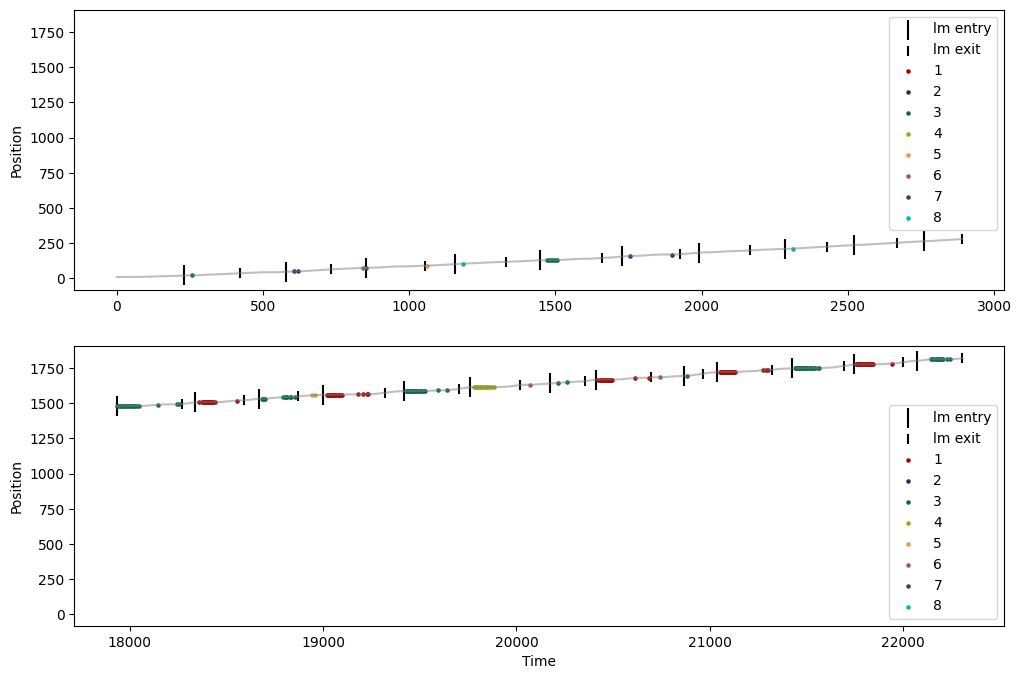

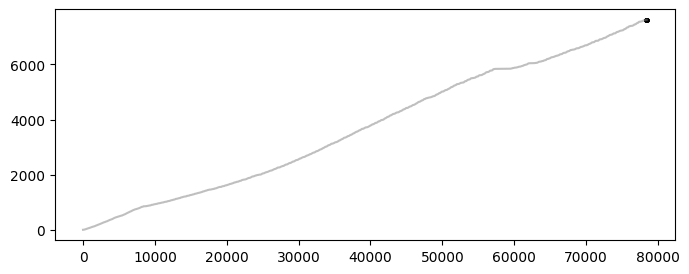

In [ ]:
# Visually confirm the lick IDs make sense
example_runs = [np.arange(0, lm_exit_idx[9]+1), np.arange(lm_entry_idx[session['rewarded_landmarks'][10]-1], lm_exit_idx[session['rewarded_landmarks'][13]+3]+1)]
# example_runs = [np.arange(0, lm_exit_idx[9]+1), np.arange(62000, 67000)]

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True)
ax = ax.ravel()

for i in range(2):
    entries = np.array(lm_entry_idx)[(np.array(lm_entry_idx) >= example_runs[i][0]) & (np.array(lm_entry_idx) <= example_runs[i][-1])]
    exits = np.array(lm_exit_idx)[(np.array(lm_exit_idx) >= example_runs[i][0]) & (np.array(lm_exit_idx) <= example_runs[i][-1])]
    
    ax[i].plot(example_runs[i], nidaq_data['position'][example_runs[i]], color='gray', alpha=0.5)
    ax[i].scatter(entries, nidaq_data['position'][entries], s=200, marker='|', color='k', label='lm entry')
    ax[i].scatter(exits, nidaq_data['position'][exits], s=50, marker='|', color='k', label='lm exit')
    
    for id in range(1,9):
        licks_in_range = licks[id][(licks[id] >= example_runs[i][0]) & (licks[id] <= example_runs[i][-1])]
        ax[i].scatter(licks_in_range, nidaq_data['position'][licks_in_range], s=5, color=hfs_palette[id-1], label=f'{id}')
    
    ax[i].legend()
    ax[i].set_ylabel('Position')
ax[1].set_xlabel('Time')

# Make sure the missing licks, if any, are only at the very end 
missing_licks = np.setxor1d(session['lick_idx'], all_licks)
fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(nidaq_data['position'], color='gray', alpha=0.5)
ax.scatter(missing_licks, nidaq_data['position'][missing_licks], s=5, color='k')

In [ ]:
# Find the maximum time-window during which the mouse is between landmarks
# time_around = 0.5
# time_window = time_around * funcimg_frame_rate # frames
# num_timebins = 2*time_window

# print(len(first_licks[5]))
# for l, lick in enumerate(first_licks[5]):
#     prev_landmark_idx = np.where(lm_exit_idx < lick)[0][-1]
#     next_landmark_idx = np.where(lm_entry_idx > lick)[0][0]

#     # Check if any landmark contains the anticipatory lick window
#     in_landmark = [
#         (lm_entry_idx[next_landmark_idx] <= lick + time_window) or (lm_exit_idx[prev_landmark_idx] >= lick - time_window)
        
#     ]
#     if any(in_landmark):
#         print(l, lick-time_window, lick+time_window)

##### Compare average lick PSTH map in goal vs non-goal vs ‘test’ vs miss goal landmarks (because of high speed or no licking) for reward-tuned neurons

In [ ]:
# Get lick PSTH and cross-condition correlations
# if reload_results:
    
conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
ids = [1,2,8,3,4]

# Get lick PSTH
lick_psth = {}
average_lick_psth = {}

for id in ids:
    event_idx = np.array([idx for i, idx in enumerate(all_first_licks) if idx in licks[id]])
    
    lick_psth[id], average_lick_psth[id] = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                event_idx=event_idx, time_around=time_around)
    
results_licks['lick_psth'] = lick_psth
results_licks['average_lick_psth'] = average_lick_psth

# Get map correlations across conditions
psths = [lick_psth[id] for id in ids]
average_psths = [average_lick_psth[id] for id in ids]

neural_analysis_helpers.plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                        save_plot=save_plot, savepath=save_path, savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons')

licks_corrs_neuron = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=False, \
                    zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                        savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

licks_corrs_population = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=True, \
                    zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                        savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename='FiringMap_correlation')

results_licks['licks_corrs_neuron'] = licks_corrs_neuron
results_licks['licks_corrs_population'] = licks_corrs_population

print(np.mean(licks_corrs_population[0]))

In [ ]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and mouse == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs_neuron = [[] for i in range(3)]
        split_corrs_population = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_first_licks)
                                                                        if idx in licks[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   
                                
            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=False, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
            split_corrs_population[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=True, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_licks['split_corrs_neuron'] = split_corrs_neuron
        results_licks['split_corrs_population'] = split_corrs_population

##### Compare average lick PSTH map in rewarded goal (in landmark) vs anticipatory goal (outside landmark) vs miss goal landmarks (because of high speed or no licking) for reward-tuned neurons

In [ ]:
# if reload_results:

conditions = ['rewarded', 'lick & miss', 'miss', 'anticip-goal']
ids = [1,2,8,5]

lick_psth = {}
average_lick_psth = {}

for id in ids:
    event_idx = np.array([idx for i, idx in enumerate(all_first_licks) if idx in licks[id]])
    
    lick_psth[id], average_lick_psth[id] = neural_analysis_helpers.get_psth(data=DF_F, neurons=neurons_considered[all_significant_neurons_reward], \
                                                                event_idx=event_idx, time_around=time_around)
    
# Get map correlations across conditions
psths = [lick_psth[id] for id in ids]
average_psths = [average_lick_psth[id] for id in ids]

neural_analysis_helpers.plot_condition_psth_map(average_psths=average_psths, conditions=conditions, zscoring=True, time_around=time_around, \
                        save_plot=save_plot, savepath=save_path, savedir='LickFiringMap_rew_miss_anticip_RewardTunedNeurons')

_ = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=False, \
                    zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                        savedir='LickFiringMap_rew_miss_anticip_RewardTunedNeurons', filename='FiringMap_correlation')

_ = neural_analysis_helpers.get_map_correlation(psths=psths, average_psths=average_psths, conditions=conditions, population=True, \
                    zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                        savedir='LickFiringMap_rew_miss_anticip_RewardTunedNeurons', filename='FiringMap_correlation')


##### Split T5

In [ ]:
# If t5, split session into sections approximately
if reload_results:

    if protocol_num == 5 and mouse == 'TAA0000066':
        split_indices = {id: {} for id in ids}
        split_corrs_neuron = [[] for i in range(3)]
        split_corrs_population = [[] for i in range(3)]

        for i in range(3):
            if i == 0:
                trials = np.arange(0, 70)   # laps 0-7
            elif i == 1:
                trials = np.arange(70, 200)     # laps 7-20
            elif i == 2:
                trials = np.arange(200, num_lms)   # laps 20-end

            for id in ids:
                if i == 0:
                    split_indices[id][i] = np.arange(0, len(np.array([i for i, idx in enumerate(all_first_licks)
                                                                        if idx in licks[id] and 
                                                ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 1:
                    split_indices[id][i] = np.arange(len(split_indices[id][i-1]), len(split_indices[id][i-1]) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]+1]))])))
                elif i == 2:
                    split_indices[id][i] = np.arange(sum(len(split_indices[id][j]) for j in range(i)), sum(len(split_indices[id][j]) for j in range(i)) + 
                                                    len(np.array([idx for i, idx in enumerate(all_first_licks) 
                                                                if idx in licks[id] and 
                                            ((idx >= lm_entry_idx[trials[0]]) & (idx <= lm_entry_idx[trials[-1]]))])))   
                                
            split_psths = [psths[j][:, split_indices[id][i], :] for j, id in enumerate(ids)]
            split_average_psths = [np.mean(psth, axis=1) for psth in split_psths]

            split_corrs_neuron[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=False, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
            split_corrs_population[i] = neural_analysis_helpers.get_map_correlation(psths=split_psths, average_psths=split_average_psths, conditions=conditions, population=True, \
                            zscoring=True, reference=0, color_scheme=hfs_palette[np.array(ids)-1], save_plot=save_plot, savepath=save_path, \
                                savedir='LickFiringMap_rew_miss_nongoal_test_RewardTunedNeurons', filename=f'FiringMap_correlation_{i}')
            
        results_licks['split_corrs_1285_neuron'] = split_corrs_neuron
        results_licks['split_corrs_1285_population'] = split_corrs_population

In [ ]:
# TODO: Sliding window over laps of pairwise lick correlations 
# if protocol_num == 5 and mouse == 'TAA0000066':

#     num_lms_considered = int(np.round((num_lms // 10) * 10))
#     num_laps = int(num_lms_considered / num_landmarks)

#     event_indices = []
#     for i, idx in enumerate(np.arange(num_landmarks, num_lms_considered)):
#         event_indices.append(lm_entry_idx[idx] - midpoints_before[i])

#     # Get between-landmark PSTH
#     between_landmark_psth, average_between_landmark_psth = get_landmark_psth(data=DF_F, neurons=neurons_considered, event_idx=event_indices, \
#                                                                 num_landmarks=num_landmarks, time_around=time_around)
    
    
#     window_size = 5     # laps 
#     before_rew_idx = {}    
#     for g, goal in enumerate(ABCD_goals):
#         before_rew_idx[goal] = np.array([idx for idx in session['rewarded_landmarks'] \
#                                 if session['all_lms'][idx] == session['goal_landmark_id'][goal-1]]) - num_landmarks  # shift indices back - first lap is not considered
        
#         num_windows = len(before_rew_idx[goal]) 

#     # Get rolling before-reward avg
#     rolling_avg_before_reward_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
#     for i in range(num_windows-window_size):
#         psths_considered = np.concatenate([between_landmark_psth[:, before_rew_idx[goal][i]:before_rew_idx[goal][i+window_size]:num_landmarks, :] for goal in ABCD_goals], axis=1)
#         # shape: num_neurons x window_size * num_goals x num_timebins

#         rolling_avg_before_reward_psth[:, i, :] = np.mean(psths_considered, axis=1) 
#         # shape: num_neurons x num_windows x num_timebins

#     # Get rolling before-test avg
#     valid_before_test_idx = np.array([idx for idx in session['test_idx'] if (idx > session['rewarded_landmarks'][0] and idx < session['rewarded_landmarks'][-1]+3)]) - num_landmarks  # shift indices back - first lap is not considered
#     num_windows = int(len(valid_before_test_idx - window_size + 1))
#     rolling_avg_before_test_psth = np.zeros((between_landmark_psth.shape[0], num_windows-window_size, between_landmark_psth.shape[2])) 
    
#     for i in range(num_windows-window_size):
#         rolling_avg_before_test_psth[:, i, :] = np.mean(between_landmark_psth[:, valid_before_test_idx[i]:valid_before_test_idx[i+window_size]:num_landmarks, :], axis=1)

#     # Get the pairwise correlations of rolling lap blocks
#     conditions = ['before-reward', 'before-test']
#     average_psths = [rolling_avg_before_reward_psth, rolling_avg_before_test_psth]

#     within_corrs, across_corrs, condition_pairs = get_rolling_map_correlation(average_psths, conditions, population=False, \
#                                                                               zscoring=True, color_scheme=None, ax=None, save_plot=False, \
#                                                                                 savepath='', savedir='', filename='')
    
#     # Get correlation matrix of average psths in rolling lap blocks
#     similarity_matrices = get_window_similarity_matrix(average_psths, conditions, population=False, zscoring=True, plot=True)

In [ ]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_licks.items()})

#### Speed (and acceleration) analysis

In [ ]:
# Initialize saving variables
save_filename = os.path.join(save_path, f'T{protocol_num}_speed_analysis.npz')
reload_results = False

if os.path.exists(save_filename) and not reload_results:
    results_speed = np.load(save_filename, allow_pickle=True)
else: 
    reload_results = True
    results_speed = {}

In [ ]:
# Bin speed 
# TODO: change the number of bins? 
if reload_results:
    
    speed = nidaq_data['speed']
    binned_speed = np.linspace(speed.min(), speed.max(), 21)
    # print(binned_speed) 

    # Bin acceleration
    # dt = 1 / nidaq_sampling_rate
    # acceleration = np.diff(speed) / dt
    # acceleration = np.insert(acceleration, 0, acceleration[0])  # Prepend
    # binned_acceleration = np.linspace(acceleration.min(), acceleration.max(), 21)
    # print(binned_acceleration) 

    # Calculate the average firing rate per speed / acceleration bin for each neuron 
    speed_firing_rate = np.zeros((num_neurons_considered, len(binned_speed) - 1))
    # acceleration_firing_rate = np.zeros((num_neurons_considered, len(binned_acceleration) - 1))

    for n, neuron in enumerate(neurons_considered):
        speed_firing_rate[n, :], _, _ = binned_statistic(speed, DF_F[neuron, :-1], statistic='mean', bins=binned_speed)
        # acceleration_firing_rate[n, :], _, _ = binned_statistic(acceleration, DF_F[neuron, :-1], statistic='mean', bins=binned_acceleration)

    results_speed['speed_firing_rate'] = speed_firing_rate

In [ ]:
# Plot distribution of firing rates for different speeds 
if reload_results:

    remaining_neurons = np.where(~np.isin(neurons_considered, neurons_considered[all_significant_neurons_reward]))[0]

    # Sort neurons according to max firing rate for each neuron
    # preferred_bins = np.nanargmax(speed_firing_rate, axis=1)  # shape: (num_neurons,)
    # sorted_indices = np.argsort(preferred_bins)
    # sorted_speed_firing_rate = speed_firing_rate[sorted_indices, :]

    bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2
    xtick_idx = [0, len(bin_centers)]
    xtick_vals = np.round([bin_centers[0], bin_centers[-1]]).astype(int)

    fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True)
    ax = ax.ravel()

    # All neurons
    hm1 = sns.heatmap(speed_firing_rate, cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[0], cbar=True)
    ax[0].set_yticks([0, num_neurons_considered - 1])  
    ax[0].set_yticklabels([0, num_neurons_considered])  
    ax[0].set_title('All neurons', fontsize=10)

    cbar = hm1.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate)
    vmin = np.nanmin(speed_firing_rate)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    # Reward-tuned neurons
    hm2 = sns.heatmap(speed_firing_rate[all_significant_neurons_reward], cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[1], cbar=True)
    ax[1].set_yticks([0, len(all_significant_neurons_reward) - 1])  
    ax[1].set_yticklabels([0, len(all_significant_neurons_reward)])  
    ax[1].set_title('Reward-tuned neurons', fontsize=10)
        
    cbar = hm2.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate[all_significant_neurons_reward])
    vmin = np.nanmin(speed_firing_rate[all_significant_neurons_reward])
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    # Remaining neurons
    hm3 = sns.heatmap(speed_firing_rate[remaining_neurons], cmap='viridis', xticklabels=np.round(bin_centers, 2), \
                yticklabels=False, ax=ax[2], cbar=True)
    ax[2].set_yticks([0, len(remaining_neurons) - 1])  
    ax[2].set_yticklabels([0, len(remaining_neurons)])  
    ax[2].set_title('~Reward-tuned neurons', fontsize=10)
    
    cbar = hm3.collections[0].colorbar
    vmax = np.nanmax(speed_firing_rate[remaining_neurons])
    vmin = np.nanmin(speed_firing_rate[remaining_neurons])
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
    cbar.set_label('$\Delta$F/F0', labelpad=-5)
    cbar.ax.yaxis.label.set_rotation(270)

    for i in range(3):
        ax[i].set_xticks(xtick_idx)
        ax[i].set_xticklabels(xtick_vals)
        ax[i].set_ylabel('Neuron', labelpad=-10)
        ax[i].set_xlabel('Speed (cm/s)')
        ax[i].tick_params(axis='x', labelrotation=0)
    
    fig.suptitle('Neuron Firing Rates Across Speed Bins')
    plt.tight_layout()
    output_path = os.path.join(save_path, 'Speed')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, 'speed_firingRate_distribution.png'))
    plt.show()


In [ ]:
# Get the mean firing rate across speed bins
if reload_results:

    all_means = [speed_firing_rate, speed_firing_rate[all_significant_neurons_reward], speed_firing_rate[remaining_neurons]]
    global_min = np.nanmin(speed_firing_rate)
    global_max = np.nanmax(speed_firing_rate)

    bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2

    fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharex=False, sharey=True)
    ax = ax.ravel()

    for i in range(3): 
        data_to_plot = np.mean(all_means[i], axis=0)
        valid_bins = ~np.isnan(data_to_plot)
        valid_idx = np.where(valid_bins)[0]

        if len(valid_idx) == 0:
            xtick_idx = []
            xtick_vals = []
        else:
            xtick_idx = [valid_idx[0], valid_idx[-1]]
            xtick_vals = np.round(bin_centers[xtick_idx]).astype(int)

        ax[i].plot(bin_centers[valid_bins], data_to_plot[valid_bins], color='k', linewidth=3)

        ax[i].set_xticks(bin_centers[xtick_idx])  # Use actual bin center values for positioning
        ax[i].set_xticklabels(xtick_vals)
        ax[i].set_ylim(global_min, global_max)
        ax[i].set_yticks([global_min, global_max])
        ax[i].set_yticklabels(np.round([global_min, global_max], 2))

        ax[i].set_xlabel('Speed (cm/s)')
        ax[i].set_title(conditions[i])
        if i == 0:
            ax[i].set_ylabel('Avg $\Delta$F/F')

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

    ax[0].set_title('All neurons', fontsize=10)
    ax[1].set_title('Reward-tuned neurons', fontsize=10)
    ax[2].set_title('~Reward-tuned neurons', fontsize=10)
    fig.suptitle('Average Firing Rate Across Speed Bins')
    plt.tight_layout()

    output_path = os.path.join(save_path, 'Speed')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, 'speed_AvgFiringRate.png'))
    plt.show()

In [ ]:
# Look at the speed-related activity profile around different landmarks
if reload_results:

    conditions = ['rewarded', 'lick & miss', 'miss', 'non-goal', 'test']
    ids = [1,2,8,3,4]

    landmark_idx = {}
    for id in ids:
        if id == 1:
            landmark_idx[id] = session['rewarded_landmarks']
        elif id == 2:
            landmark_idx[id] = np.array([i for i in range(num_lms) if i in session['goals_idx'] and i not in session['rewarded_landmarks']
                                        and np.any((session['lick_idx'] >= lm_entry_idx[i]) & (session['lick_idx'] <= lm_exit_idx[i]))])
        elif id == 3:
            landmark_idx[id] = session['non_goals_idx']
        elif id == 4:
            landmark_idx[id] = session['test_idx']
        elif id == 8:
            landmark_idx[id] = np.array([i for i in range(num_lms) if i in session['goals_idx'] and i not in session['rewarded_landmarks']
                                        and not np.any((session['lick_idx'] >= lm_entry_idx[i]) & (session['lick_idx'] <= lm_exit_idx[i]))])

    assert len(landmark_idx[1]) + len(landmark_idx[2]) + len(landmark_idx[8]) == len(session['goals_idx']), 'Some landmarks have not been considered.'


In [ ]:
# Extract the activity within each landmark, binned by speed, for different groups of neurons
if reload_results:

    selected_neurons = [neurons_considered, neurons_considered[all_significant_neurons_reward], neurons_considered[remaining_neurons]]

    all_lm_speed_firing_rate = [[] for s in range(3)]
    all_average_lm_speed_firing_rate = [[] for s in range(3)]

    for s in range(3):
        lm_speed_firing_rate = {id: {} for id in ids}
        average_lm_speed_firing_rate = {id: {} for id in ids}

        for id in ids:
            if landmark_idx[id] is None:
                continue 

            fr_matrix = np.full((len(selected_neurons[s]), len(landmark_idx[id]), len(binned_speed) - 1), np.nan)
            
            for i, lm in enumerate(landmark_idx[id]):
                landmark_speed = speed[lm_entry_idx[lm] : lm_exit_idx[lm]]

                for n, neuron in enumerate(selected_neurons[s]):
                    fr_matrix[n, i, :], _, _ = binned_statistic(landmark_speed, DF_F[neuron, lm_entry_idx[lm] : lm_exit_idx[lm]], \
                                                                        statistic='mean', bins=binned_speed)      
            lm_speed_firing_rate[id] = fr_matrix

            # Calculate the average activity 
            average_lm_speed_firing_rate[id] = np.nanmean(lm_speed_firing_rate[id], axis=1)

        all_lm_speed_firing_rate[s] = lm_speed_firing_rate
        all_average_lm_speed_firing_rate[s] = average_lm_speed_firing_rate

    results_speed['all_lm_speed_firing_rate'] = all_lm_speed_firing_rate
    results_speed['all_average_lm_speed_firing_rate'] = all_average_lm_speed_firing_rate

In [ ]:
# Plot the distribution of firing rates for different speeds according to landmark ID for reward-tuned neurons
if reload_results:

    for s in range(3):
        
        all_data = np.array([all_average_lm_speed_firing_rate[s][id] for id in ids if len(all_average_lm_speed_firing_rate[s][id]) > 0])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)

        bin_centers = (binned_speed[:-1] + binned_speed[1:]) / 2

        fig, ax = plt.subplots(1, len(conditions), figsize=(12, 4), sharex=False, sharey=False)
        ax = ax.ravel()

        for i, id in enumerate(ids): 
            # Get indices of bins (columns) that contain at least one non-NaN
            if len(all_average_lm_speed_firing_rate[s][id]) == 0:
                continue
            valid_bins = ~np.all(np.isnan(all_average_lm_speed_firing_rate[s][id]), axis=0)
            valid_idx = np.where(valid_bins)[0]

            if len(valid_idx) == 0:
                xtick_idx = []
                xtick_vals = []
            else:
                xtick_idx = [valid_idx[0], valid_idx[-1]+1]
                # print(binned_speed[xtick_idx])
                xtick_vals = np.round(binned_speed[xtick_idx]).astype(int)

            hm = sns.heatmap(all_average_lm_speed_firing_rate[s][id], cmap='viridis', xticklabels=False, yticklabels=False, \
                            ax=ax[i], cbar=False, vmin=vmin, vmax=vmax)

            ax[i].set_xticks(xtick_idx)
            ax[i].set_xticklabels(xtick_vals)
            ax[i].set_xlabel('Speed (cm/s)')
            ax[i].tick_params(axis='x', labelrotation=0)
            ax[i].set_title(f'{conditions[i]}', fontsize=10)

        ax[0].set_ylabel('Neuron', labelpad=0)
        ax[0].set_yticks([0, all_average_lm_speed_firing_rate[s][1].shape[0]])
        ax[0].set_yticklabels([0, all_average_lm_speed_firing_rate[s][1].shape[0]])

        # Shared colorbar
        cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
        cbar = fig.colorbar(hm.collections[0], cax=cbar_ax)
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([str(int(vmin)), str(int(vmax))])
        cbar.set_label('$\Delta$F/F0', labelpad=-5)
        cbar.ax.yaxis.label.set_rotation(270)

        fig.suptitle('Neuron Firing Rates Across Speed Bins')

        output_path = os.path.join(save_path, 'Speed')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'speed_firingRate_distribution_landmarks_Neurons{s}.png'))
        plt.show()


In [ ]:
# Plot average firing rate across neurons per speed bin
if reload_results:

    for s in range(3):

        all_means = [np.nanmean(all_average_lm_speed_firing_rate[s][id], axis=0) for id in ids if len(all_average_lm_speed_firing_rate[s][id]) > 0]
        global_min = np.nanmin(all_means)
        global_max = np.nanmax(all_means)

        fig, ax = plt.subplots(1, len(conditions), figsize=(12, 3), sharex=False, sharey=True)
        ax = ax.ravel()

        for i, id in enumerate(ids): 
            if len(all_average_lm_speed_firing_rate[s][id]) == 0:
                continue
            data_to_plot = np.nanmean(all_average_lm_speed_firing_rate[s][id], axis=0)
            valid_bins = ~np.isnan(data_to_plot)
            valid_idx = np.where(valid_bins)[0]

            if len(valid_idx) == 0:
                xtick_idx = []
                xtick_vals = []
            else:
                xtick_idx = [valid_idx[0], valid_idx[-1]]
                xtick_vals = np.round(bin_centers[xtick_idx]).astype(int)

            ax[i].plot(bin_centers[valid_bins], data_to_plot[valid_bins], color=hfs_palette[id-1], linewidth=3)

            ax[i].set_xticks(bin_centers[xtick_idx])  # Use actual bin center values for positioning
            ax[i].set_xticklabels(xtick_vals)
            ax[i].set_ylim(global_min, global_max)
            ax[i].set_yticks([global_min, global_max])
            ax[i].set_yticklabels(np.round([global_min, global_max], 2))

            ax[i].set_xlabel('Speed (cm/s)')
            ax[i].set_title(conditions[i])
            if i == 0:
                ax[i].set_ylabel('Avg $\Delta$F/F')

            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)

        fig.suptitle('Average Firing Rate Across Speed Bins')
        plt.tight_layout()

        output_path = os.path.join(save_path, 'Speed')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'speed_AvgFiringRate_landmarks_Neurons{s}.png'))
        plt.show()

In [ ]:
# Save results 
if reload_results:
    np.savez(save_filename, **{k: np.array(v, dtype=object) for k, v in results_speed.items()})